# Finding the Main Factors Affecting Teen Birth Rate
## Summary
This project looks at various socio-economic and political data to find factors that strongly effect the teen birth rate (15-19 year olds) for each state in the US. I aggregated, cleaned, and analyzed data factors related to religion, education, politics, poverty rate and median income, abortion rates for teens and overall, sexual education approaches, and race.

I attempted to find relationships between these explanatory variables using teen birth rate as the response for 51 samples (the 50 states + Washington DC). The importance of various features were selected using univariate selection methods (i.e. correlations), as well as various modeling techniques. The results were aggregated and final selection was made based on additive r-squared analysis.

## Key Questions Explored:
- Which factor(s) most strongly affect teen birth rate for the various states?
- With a reduced feature set, how much variance of the teen birth rate response can be explained?

## Techniques used:
- Univariate Feature Selection
- Ridge / Lasso / Mutual Info Regression
- Random Forest Feature Importance
- Boruta Feature Selection
- Adjusted R-Squared Analysis

## Key Findings:
- Poverty rate, religiosity, and political leanings in each state appears to have the strongest effect on teen birth rate.
- The plot below shows the normalized teen birth rate responses, as well as the normalized poverty rate, religiosity, and republican lean in the 2008 and 2012 elections. Darker red circles to the right indicate higher relative values of each respective category.

<img src="final_result.png"  alt="Drawing" style="width: 800px; float:center;" />

## Data Sources:
- Teen birth rates: https://www.hhs.gov/ash/oah/adolescent-development/reproductive-health-and-teen-pregnancy/teen-pregnancy-and-childbearing/trends/index.html
- Religiosity by state: http://www.pewforum.org/religious-landscape-study/state/california/#importance-of-religion-by-state
- GDP by state: https://en.wikipedia.org/wiki/List_of_U.S._states_by_GDP#cite_note-2
- Election results: https://en.wikipedia.org/wiki/United_States_presidential_election
- Population, Land area: http://www.ipl.org/div/stateknow/popchart.html
- Public education spending: http://www.governing.com/gov-data/education-data/state-education-spending-per-pupil-data.html
- Poverty rate: https://en.wikipedia.org/wiki/List_of_U.S._states_by_poverty_rate
- Median income by state: https://en.wikipedia.org/wiki/List_of_U.S._states_by_income
- Abortion rate by state: http://www.kff.org/womens-health-policy/state-indicator/abortion-rate/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
- Abortion percentage by age: http://www.kff.org/womens-health-policy/state-indicator/distribution-of-abortions-by-age/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
- Sex Education by state: https://www.guttmacher.org/state-policy/explore/sex-and-hiv-education
- Overall Sex Education Score from Graphiq: https://graphiq-stories.graphiq.com/stories/23028/states-worst-sex-education
- Population breakdown by race: http://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

# 1. Loading and Cleaning Dataset
The data from the sources listed above were compiled into a single .csv file. The major factors to be studied are listed after the next cell. A brief rundown of the various columns includes:
- Religion Importance = Pew survey results for importance of religion
- Education of Level = percent of state residents with certain education level
- Political vote share = Democratic and Republican vote shares in 2008, 2012, and 2016 elections
- Median Income and Poverty Level = median income and poverty rate for citizens in each state
- 2014 spend per student = state funding for public education
- Sex Education Features = the laws and guidelines states follow for their sex ed programs (binary)
- Sex Ed score = an aggregated sexual education metric from Graphiq (see above in sources)
- White/Black/Hispanic/Asian = breakdown of state population by race

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from my_plot import PrettyPlot
PrettyPlot(plt);

In [2]:
data = pd.read_csv('teen_pregnancy_rate.csv')

data=data[0:51]
data.head()

State Code  teen_birth_rate religion_very_important  \
0     Alabama   AL             32.0                     77%   
1      Alaska   AK             27.8                     41%   
2     Arizona   AZ             29.9                     51%   
3    Arkansas   AR             39.5                     70%   
4  California   CA             21.1                     47%   

  religion_somewhat_important religion_not_too_important  \
0                         13%                         6%   
1                         29%                        13%   
2                         24%                        13%   
3                         16%                         7%   
4                         26%                        13%   

  religion_not_at_all_important education_high_school education_bachelors  \
0                            4%                84.30%              23.50%   
1                           16%                92.10%              28.00%   
2                           11%                86.00%              27.50%   
3                            5%                84.80%              21.10%   
4                           14%                81.80%              31.40%   

  education_advanced      ...      sex_ed_importance_of_abstinence  \
0              8.70%      ...                               stress   
1             10.10%      ...                                   na   
2             10.20%      ...                               stress   
3              7.50%      ...                               stress   
4             11.60%      ...                                cover   

  sex_ed_importance_marriage_only sex_ed_sexual_orientation  \
0                               X                  negative   
1                              na                        na   
2                             NaN                       NaN   
3                               X                       NaN   
4                             NaN                 inclusive   

  sex_ed_negative_outcomes_teen_sex sex_ed_family_communication sex_ed_score  \
0                                 X                         NaN        18.35   
1                                na                          na         3.53   
2                                 X                         NaN         0.18   
3                               NaN                         NaN        42.21   
4                               NaN                           X        25.28   

  white_percent black_percent hispanic_percent asian_percent  
0          0.65          0.27             0.04          0.04  
1          0.58          0.03             0.06          0.07  
2          0.51          0.04             0.37          0.03  
3          0.74          0.15             0.07          0.02  
4          0.39          0.06             0.38          0.15  

[5 rows x 41 columns]

## 1.1 Imputing Null Values
A number of the columns have missing values as shown in the following cell. Further, many of the values will require converting to ordinal or categorical variables.

In [3]:
data.isnull().sum()[data.isnull().sum() > 0]

sex_ed_mandated                      21
hiv_ed_mandated                      11
sex_ed_medically_accurate            33
sex_ed_age_appropriate               19
sex_ed_unbiased                      38
sex_ed_cannot_promote_religion       44
sex_ed_must_discuss_contraception    23
sex_ed_importance_of_abstinence       5
sex_ed_importance_marriage_only      23
sex_ed_sexual_orientation            30
sex_ed_negative_outcomes_teen_sex    28
sex_ed_family_communication          32
dtype: int64

The following cell shows a sample of the columns with missing and nominal data. 
- 'X' values mean the state DOES follow the respective guideline
- 'NaN' cells mean the state DOES NOT follow the guideline 
- 'na' cells show data was not available
- 'stress' and 'cover' indicate how much schools emphasize a respective topic.  

In [4]:
data.loc[:5,'sex_ed_mandated':'sex_ed_family_communication']

sex_ed_mandated hiv_ed_mandated sex_ed_medically_accurate  \
0             NaN               X                       NaN   
1              na              na                        na   
2             NaN             NaN                       NaN   
3             NaN             NaN                       NaN   
4               X               X                         X   
5             NaN             NaN                         X   

  sex_ed_age_appropriate sex_ed_unbiased sex_ed_cannot_promote_religion  \
0                      X             NaN                            NaN   
1                     na              na                             na   
2                      X             NaN                            NaN   
3                    NaN             NaN                            NaN   
4                      X               X                              X   
5                      X               X                            NaN   

  sex_ed_must_discuss_contraception sex_ed_importance_of_abstinence  \
0                                 X                          stress   
1                                na                              na   
2                               NaN                          stress   
3                               NaN                          stress   
4                                 X                           cover   
5                                 X                           cover   

  sex_ed_importance_marriage_only sex_ed_sexual_orientation  \
0                               X                  negative   
1                              na                        na   
2                             NaN                       NaN   
3                               X                       NaN   
4                             NaN                 inclusive   
5                             NaN                 inclusive   

  sex_ed_negative_outcomes_teen_sex sex_ed_family_communication  
0                                 X                         NaN  
1                                na                          na  
2                                 X                         NaN  
3                               NaN                         NaN  
4                               NaN                           X  
5                               NaN                           X

All of the cells with missing data or nominal values will be changed into numeric values according to the mapping scheme below.
- "X" values that indicate schools follow the guideline will be converted to 1.
- NaN values that indicate schools do NOT follow the guidline will be converted to 0.
- Topics that are stressed, covered, and inclusive will be given 2, 1, and 1 values respectively.
- Topics that are covered negatively will be given a -1 value.

The remaining "na" cells, which are not available, will be filled using the mean of each columns' values following mapping.

In [5]:
yes_no = {
    'X': 1,
    float('nan'): 0,
    'stress': 2,
    'cover': 1,
    'negative': -1,
    'inclusive': 1
}

for col in data.loc[:5,'sex_ed_mandated':'sex_ed_family_communication'].columns:
    data[col] = data[col].map(yes_no)
    
data = data.fillna(data.mean()).round(2)
data.loc[:5,'sex_ed_mandated':'sex_ed_family_communication']

sex_ed_mandated  hiv_ed_mandated  sex_ed_medically_accurate  \
0             0.00             1.00                       0.00   
1             0.54             0.76                       0.28   
2             0.00             0.00                       0.00   
3             0.00             0.00                       0.00   
4             1.00             1.00                       1.00   
5             0.00             0.00                       1.00   

   sex_ed_age_appropriate  sex_ed_unbiased  sex_ed_cannot_promote_religion  \
0                    1.00             0.00                            0.00   
1                    0.59             0.17                            0.04   
2                    1.00             0.00                            0.00   
3                    0.00             0.00                            0.00   
4                    1.00             1.00                            1.00   
5                    1.00             1.00                            0.00   

   sex_ed_must_discuss_contraception  sex_ed_importance_of_abstinence  \
0                               1.00                             2.00   
1                               0.45                             1.48   
2                               0.00                             2.00   
3                               0.00                             2.00   
4                               1.00                             1.00   
5                               1.00                             1.00   

   sex_ed_importance_marriage_only  sex_ed_sexual_orientation  \
0                             1.00                      -1.00   
1                             0.45                       0.19   
2                             0.00                       0.00   
3                             1.00                       0.00   
4                             0.00                       1.00   
5                             0.00                       1.00   

   sex_ed_negative_outcomes_teen_sex  sex_ed_family_communication  
0                               1.00                         0.00  
1                               0.33                         0.24  
2                               1.00                         0.00  
3                               0.00                         0.00  
4                               0.00                         1.00  
5                               0.00                         1.00

## 1.2 Cleaning Strings
All strings containing special symbols including dollar signs, percent symbols, etc. will be removed and values converted to float.

In [6]:
import re

def column_clean(col):
    cleaned_col = float(re.sub('[$%,]', '', str(col)))
    return cleaned_col

In [7]:
numeric_data = data.iloc[:,2:]
numeric_col = numeric_data.columns

for col in numeric_col:
    data[col] = data[col].apply(column_clean)

The final cleaning will be to convert the teen birth rate into a percentage. Currently, the teen birth rate is listed as number of births per 1000 adolescent females aged 15-19. I will divide this column by 10 to convert it to a percentage, e.g. instead of 24 births per 1000 females aged 15-19, it will be 2.4% of females aged 15-19.

In [8]:
data['teen_birth_rate'] = data['teen_birth_rate'] / 10

# 2. Feature Exploration and Importance Ranking
This section will show the exploration of the various feature importances. I will use a variety of methods to compare each feature's relationship with the teen birth rate response variable. Initially, I will show simple Pearson's correlation coefficients.

The first modeling methods will use L1 and L2 regularized regression (Lasso and Ridge respectively) to compare the feature coefficient weights. Next, significant features will be determined with Mutual Info Regression, which uses an entropy estimation based on k-nearest neighbors to measure the dependency of two variables. 

The final two methods will use Random Forest Feature Importance to find significant features. Initially, I will fit a standard Random Forest model and simply check the feature importance attribute. The second Boruta method utilizes Random Forests with shadow features to find significant features and gives importance rankings to each feature.

After determining the relationships amongst features with all the separate methods, I will aggregate the normalized results and then use an adjusted r-squared analysis to find the amount of new information provided by each subsequent variable when predicting teen birth rate.

## 2.1 Useful Functions
Below, I split the data into the feature and response X, y variables. I also create a normalized feature variable for the regression analysis to ensure that coefficent weights can be properly compared.

The two functions generate evaluate the model accuracy and plot the feature importance or weights. The cross_val_mean function performs cross-validation using the leave-one-out (LOOCV) method since there are only 51 samples. The error for the out-of-sample is calculated using the root-mean-squared-error (RMSE) and reported. For reference, the teen birth rates range from about 1% to 4%, with the full summary statistics shown below. The LOOCV RMSE's were generally on the order of 0.3–0.4, meaning the model has reasonable accuracy.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

y = data.teen_birth_rate
X = data.select_dtypes(include=['float']).drop('teen_birth_rate', axis=1)

scale = StandardScaler()
X_norm = scale.fit_transform(X)

In [57]:
y.describe()

count    51.000000
mean      2.449608
std       0.779759
min       1.060000
25%       1.920000
50%       2.320000
75%       2.850000
max       3.950000
Name: teen_birth_rate, dtype: float64

In [10]:
def cross_val_mean(X, estimator):
    results = cross_val_score(estimator, X, y, cv=51, scoring='neg_mean_squared_error')
    results = np.sqrt(abs(results))
    print('Cross-validated RMSE: %s' %round(np.mean(results), 3))

In [11]:
def plot_feature_importance(results, label='', asc=True, barh=True, figsize=(6,12), fontsize=12):
    series = pd.Series(results, index=X.columns).sort_values(ascending=asc)
    
    if barh == True:
        ax = series.plot.barh(figsize=figsize, fontsize=fontsize)
        ax.set_xlabel(label, fontsize=fontsize+1)
    else:
        ax = series.plot.bar(figsize=figsize, fontsize=fontsize)
        ax.set_ylabel(label, fontsize=fontsize+1)
        
    return ax

## 2.2 Univariate Correlations
The correlations between each feature and the teen birth rate variable are shown below. Features that positively correlate with teen birth rate include religion being important to the state's population, poverty rate, states that favored John McCain and Mitt Romney in the 2008 / 2012 presidential elections, and sexual education that teaches the importance of marriage only sex and abstinence.

Features that negatively correlate with teen birth rate include religion not being important to the state's population, increasing median income, Barrack Obama vote shares in 2008 / 2012, and increased bachelor degree rate.

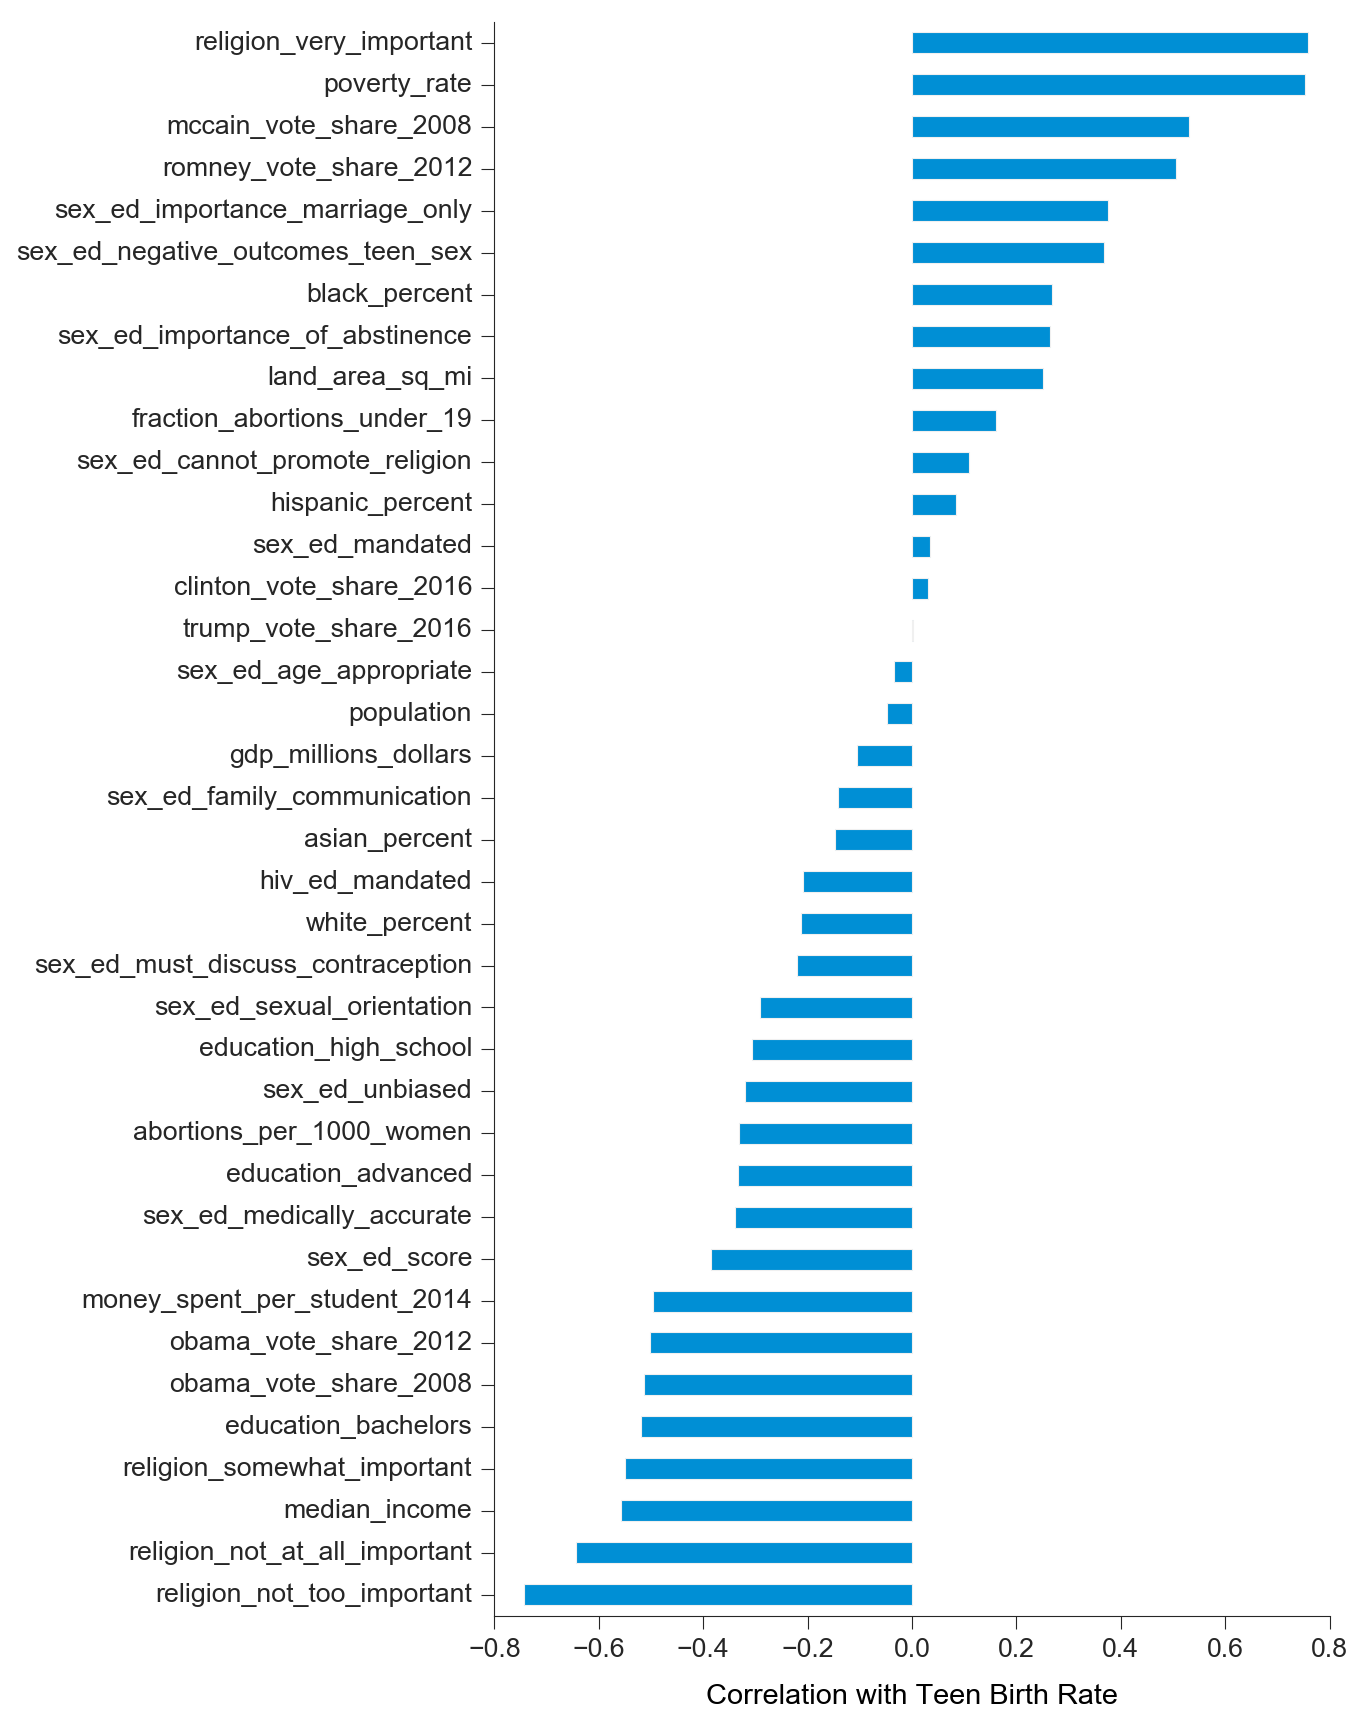

In [12]:
plt.rcParams['font.size'] = 14
correlations = data.corr()['teen_birth_rate']
plot_feature_importance(correlations[1:], label='Correlation with Teen Birth Rate');

## 2.3 Ridge Regression
Below, I create an L2 regularized Ridge regression model with the normalized feature set. The coefficient weights are plotted. The optimized alpha value provided an out-of-sample RMSE of 0.348. 

Some of the most critical factors vary from the previous correlation analysis. Poverty remains very important, but the vote shares seem less critical. However, the religiosity remains important for both positively and negatively affecting the teen birth rate. 

Cross-validated RMSE: 0.348


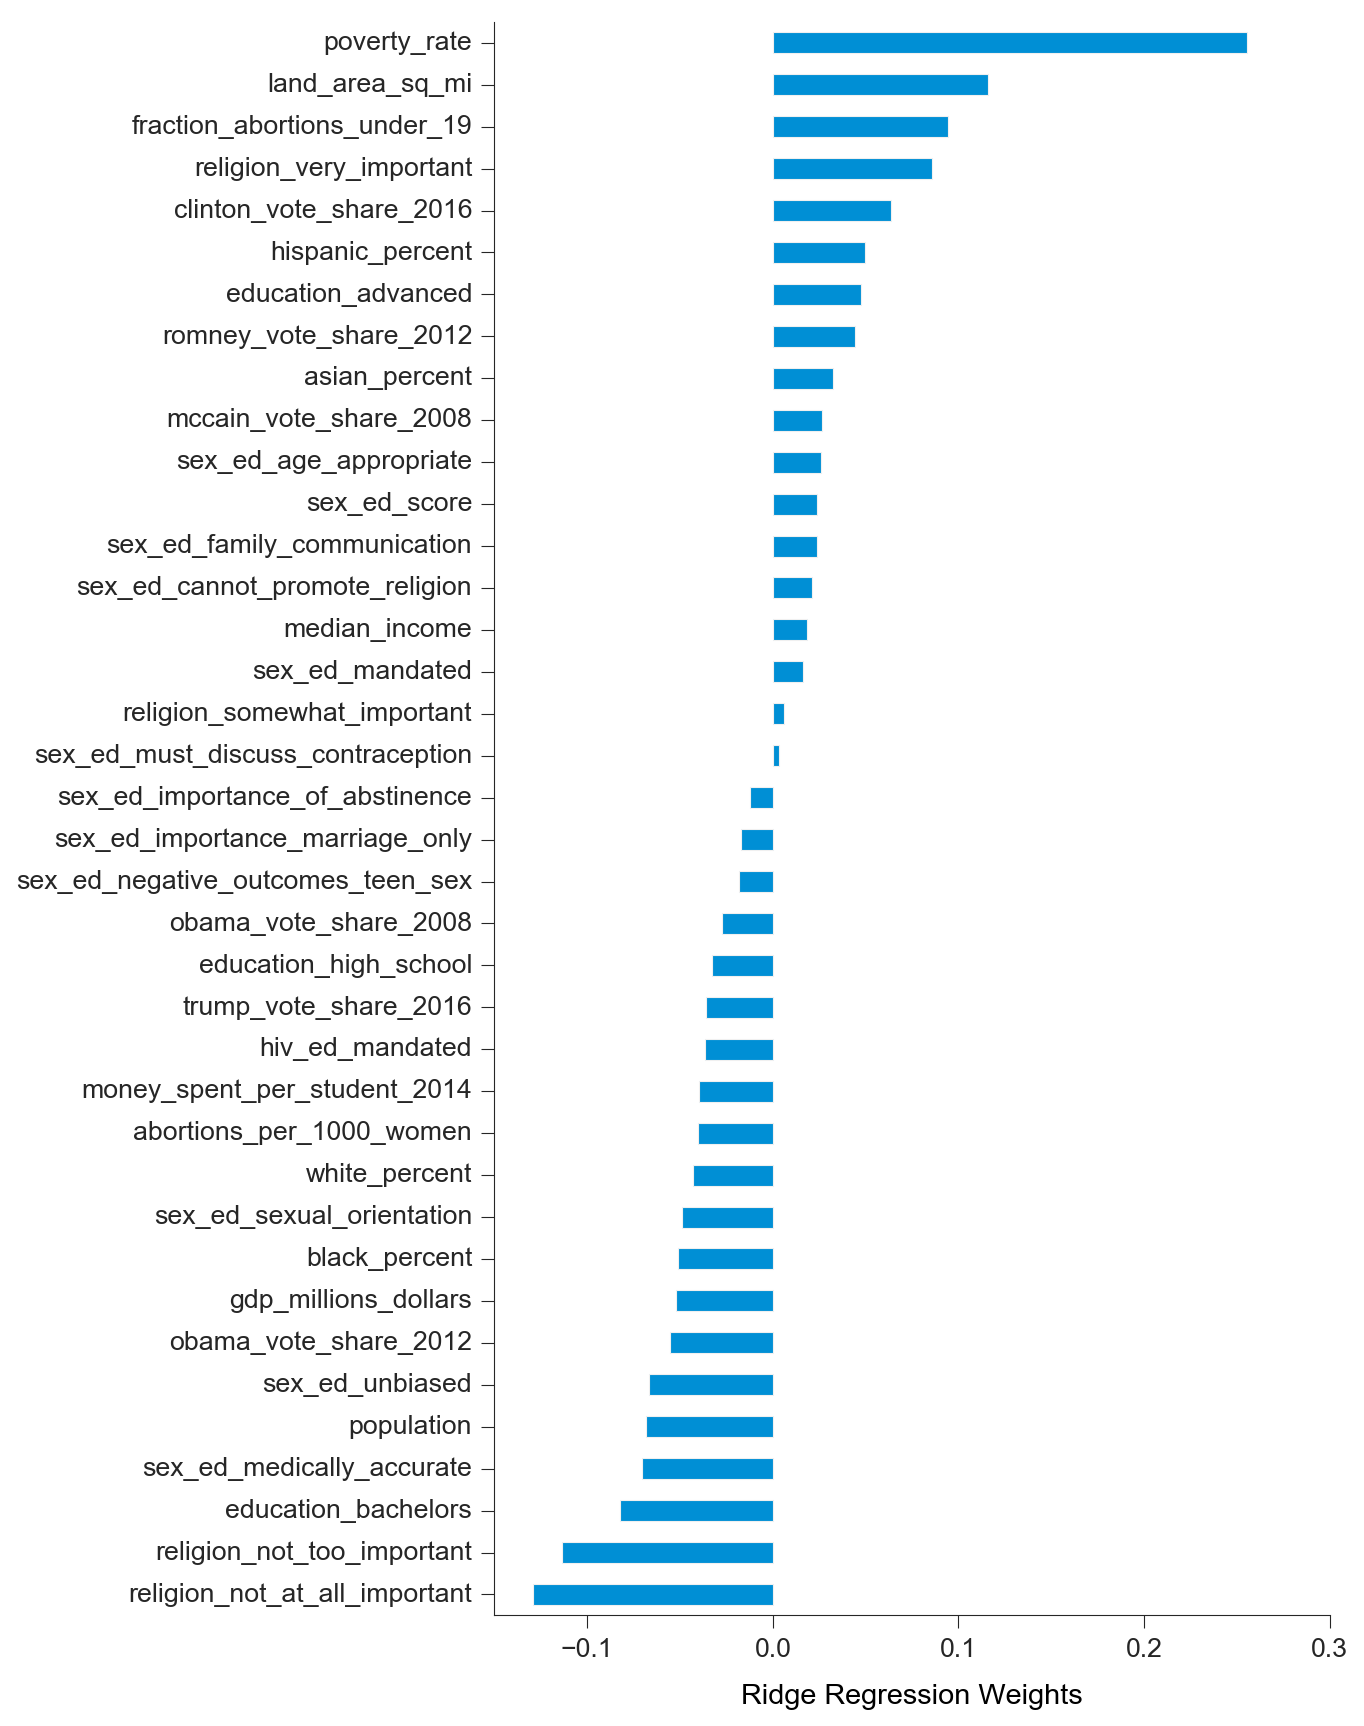

In [13]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
cross_val_mean(X_norm, ridge)

ridge.fit(X_norm, y)
plot_feature_importance(ridge.coef_, label='Ridge Regression Weights');

## 2.4 Lasso Regression
The sparse L1 Lasso regression results are shown below. This model actually provides slightly lower RMSE of 0.329. Poverty rate again shows up as a critical feature, along with median income, education, and religiosity.

Cross-validated RMSE: 0.329


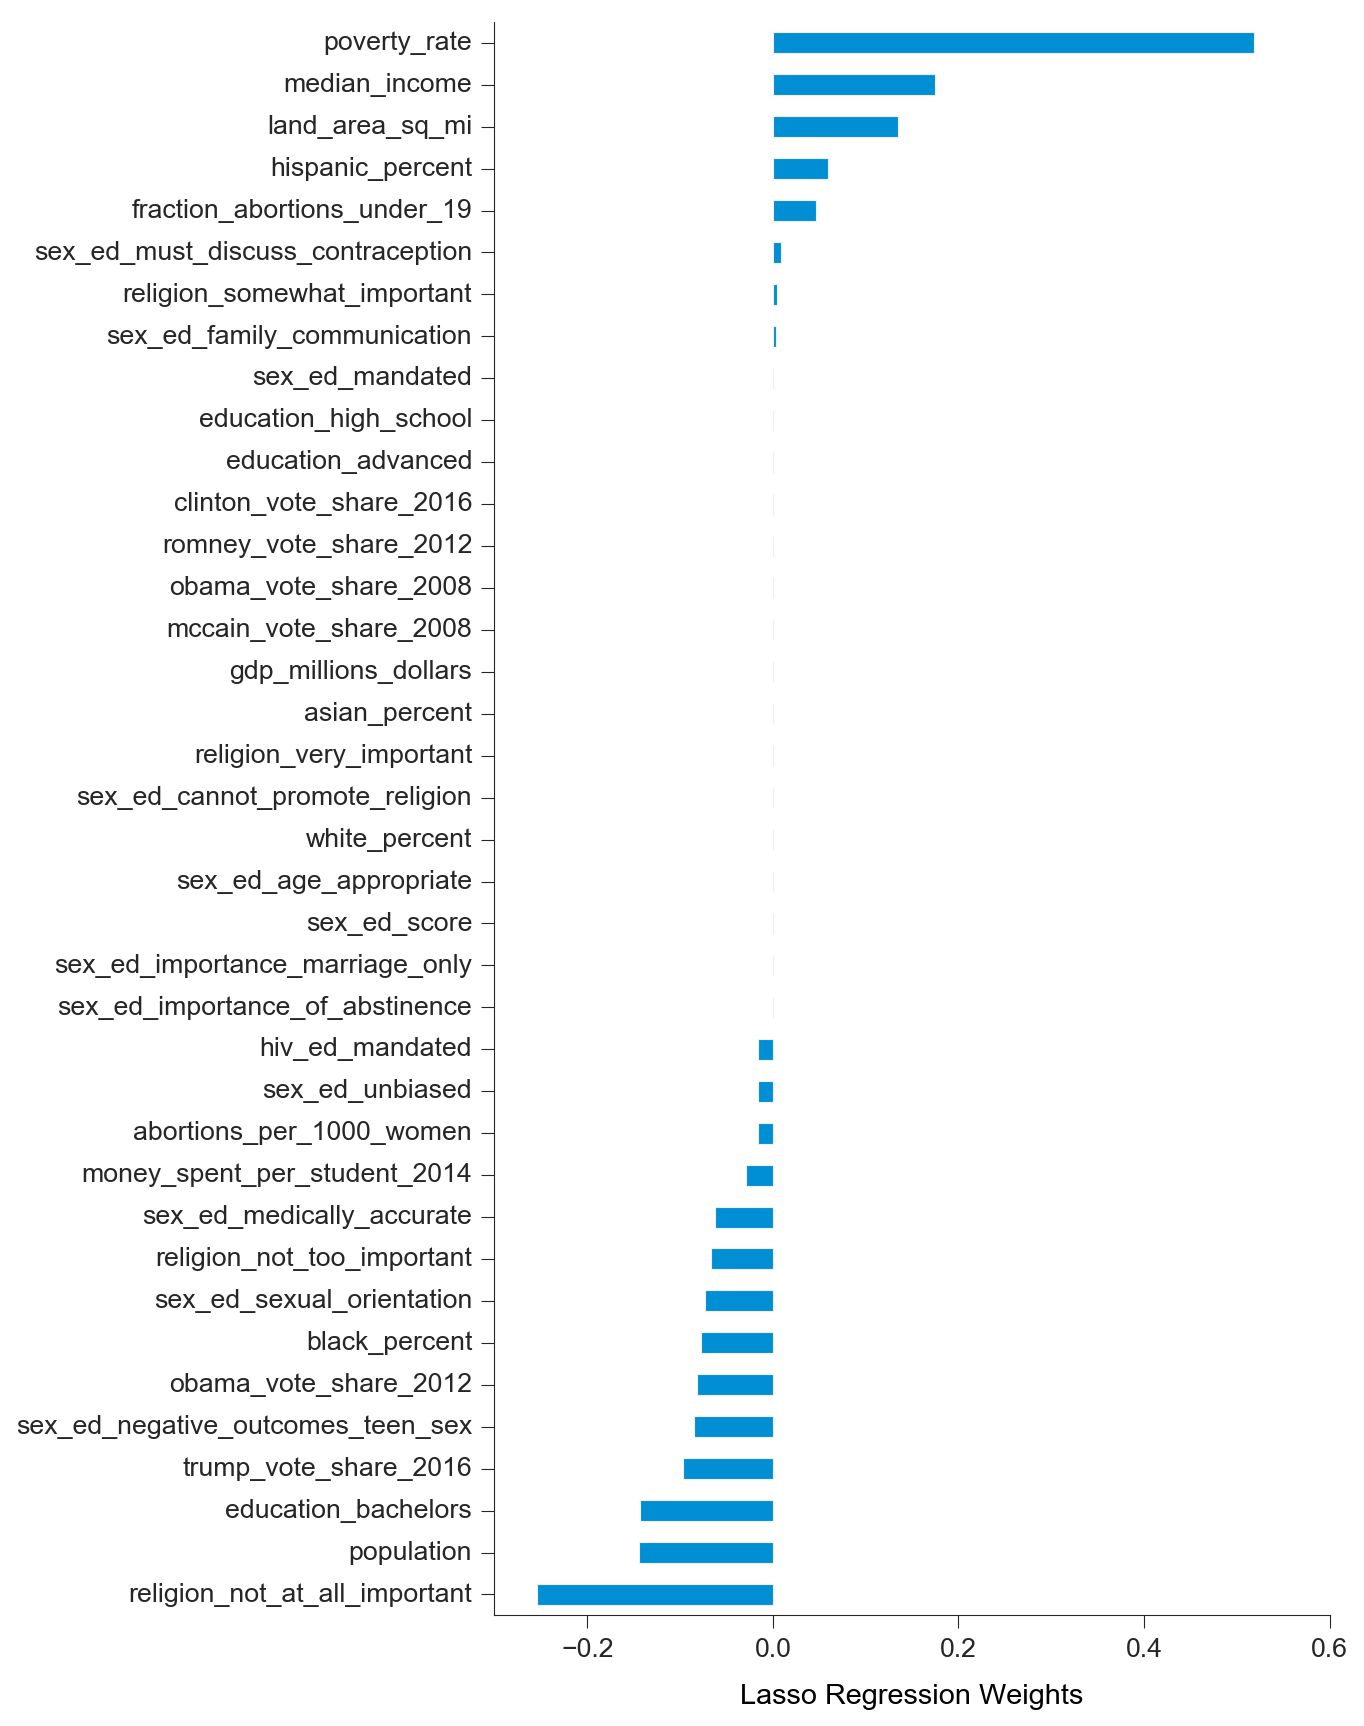

In [14]:
from sklearn.linear_model import Lasso

lass = Lasso(alpha=0.01)
cross_val_mean(X_norm, lass)

lass.fit(X_norm, y)
plot_feature_importance(lass.coef_, label='Lasso Regression Weights');

## 2.5 Mutual Info Regression
The mutual info regression feature importances below do not show directionality of relationship between each feature and the teen birth rate response. However, it does show relative importance amongst the various features, with poverty rate and medican income as most important, followed by religion and political metrics.

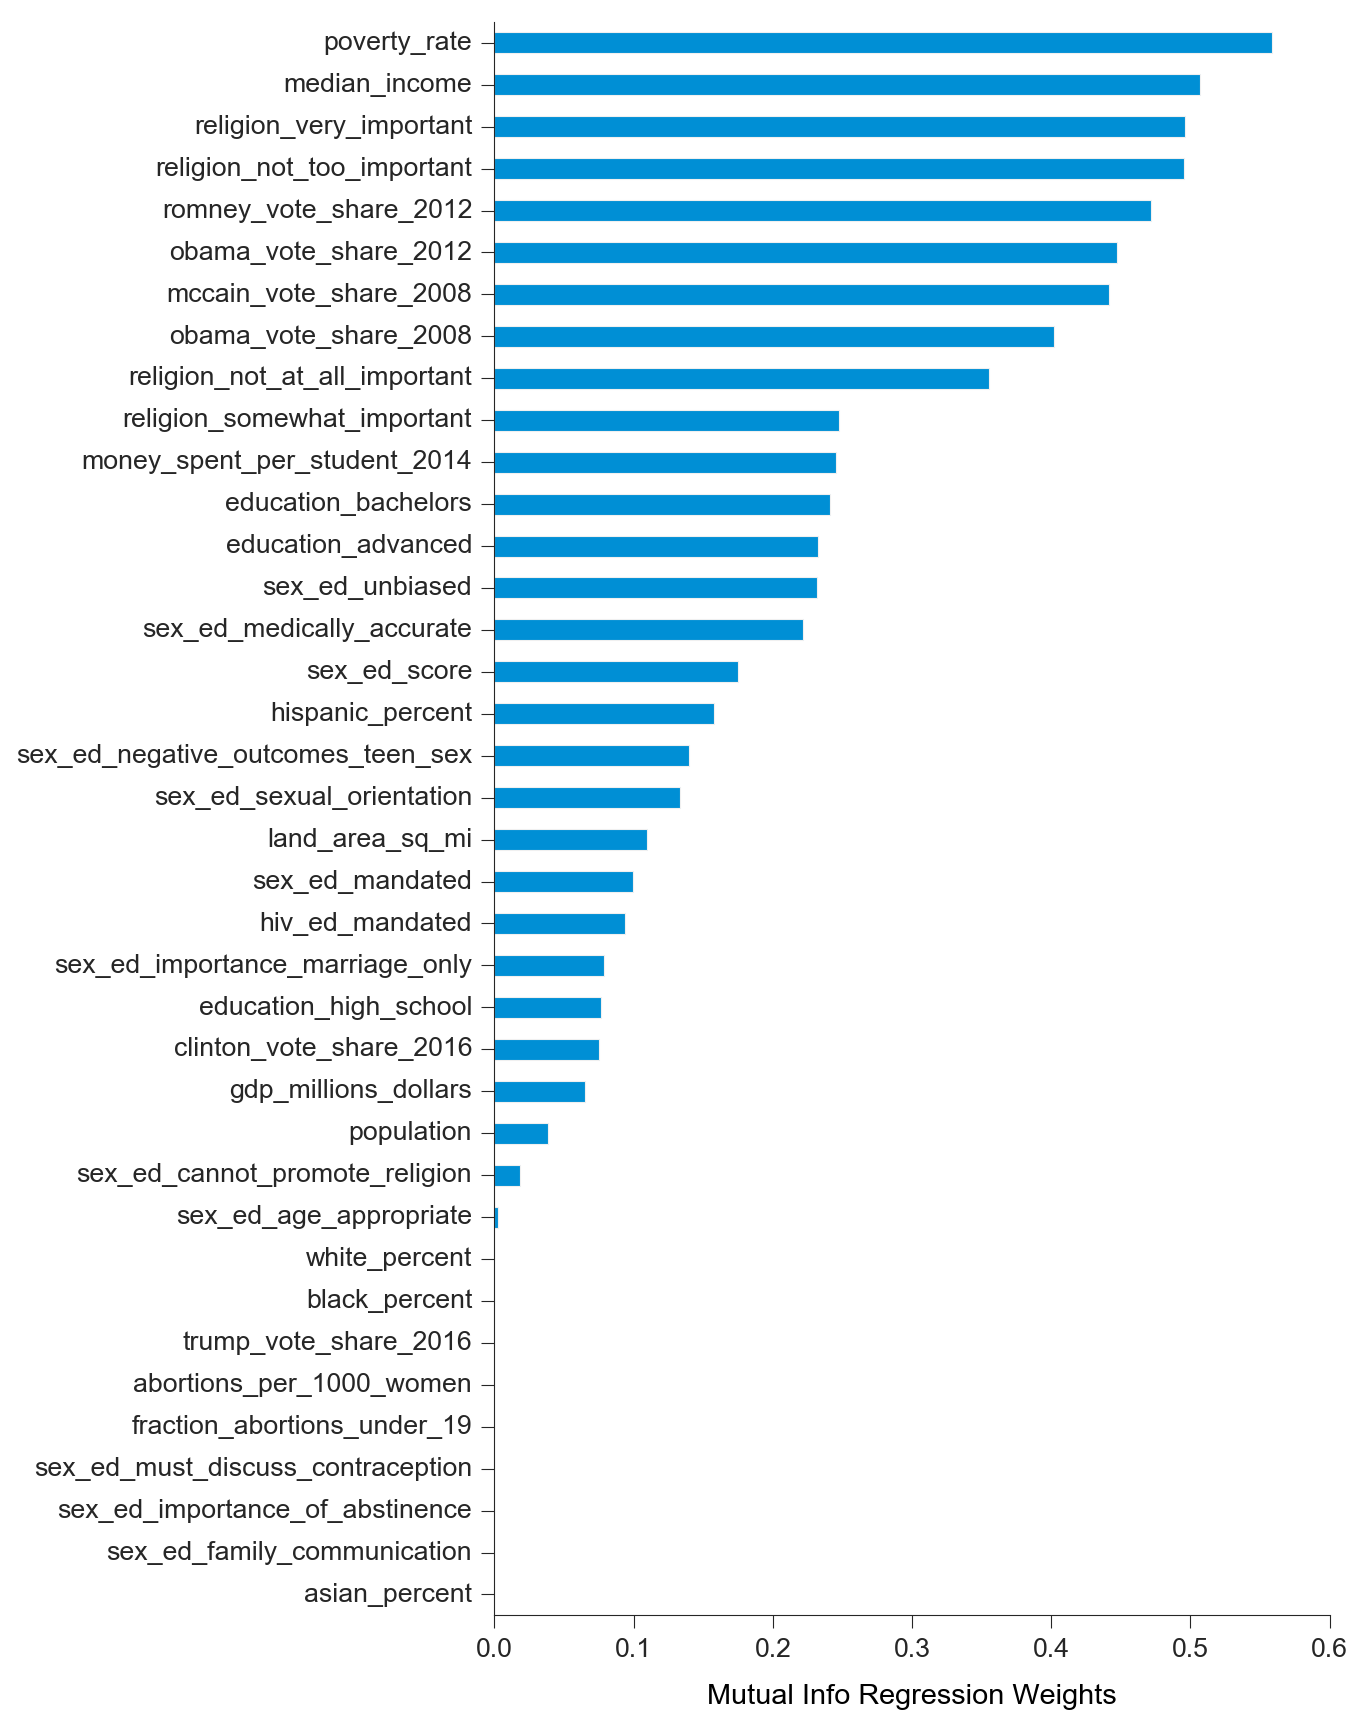

In [15]:
from sklearn.feature_selection import mutual_info_regression

mif_scores = mutual_info_regression(X_norm, y, discrete_features='auto', n_neighbors=3, copy=True)
plot_feature_importance(mif_scores, 'Mutual Info Regression Weights');

## 2.6 Random Forest Feature Importance
The Random Forest model below provides an out-of-sample RMSE of 0.373, which is slightly worse than the two linear models. However, its feature importances match reasonably well with the other results, showing religion, poverty rate, political leanings, and education as important features.

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
cross_val_mean(X, rf)

Cross-validated RMSE: 0.373


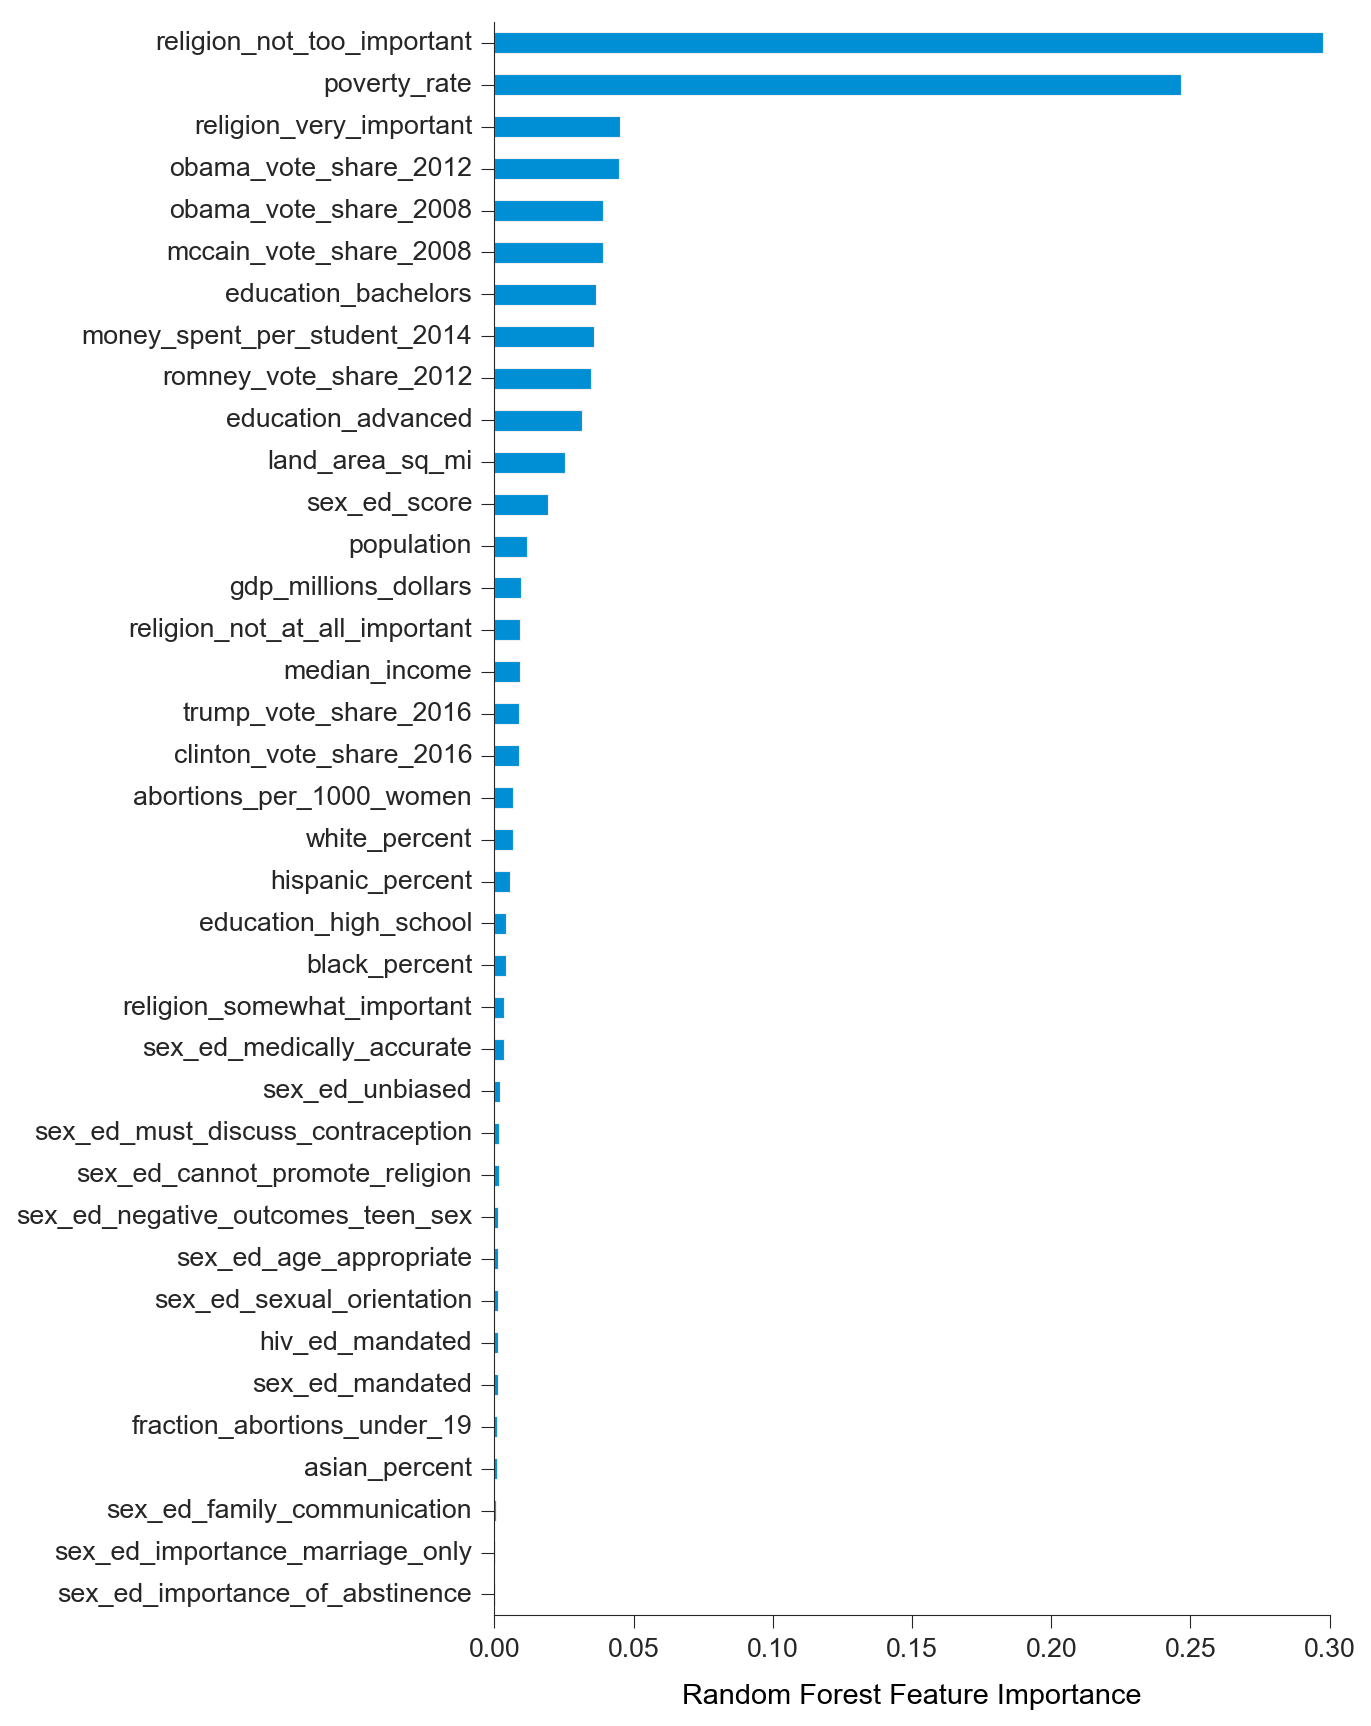

In [17]:
rf.fit(X, y)
plot_feature_importance(rf.feature_importances_, label='Random Forest Feature Importance');

## 2.7 Boruta Selection
Boruta is a multivariate feature selection method that uses shadow features (randomly shuffling the data) to compare the importance of each feature to a random variable. Using a binomial distribution to the compare the shadow and regular feature, the most critical factors can be determined (shown as rank 1 below). In this case, poverty rate, religion, vote shares, and education again show up as critical, along with the money spent per student in each state.

In [18]:
from boruta_py import BorutaPy

boruta_selector = BorutaPy(RandomForestRegressor(n_jobs=-1), n_estimators='auto', verbose=0)
boruta_selector.fit(X.values, y.values);

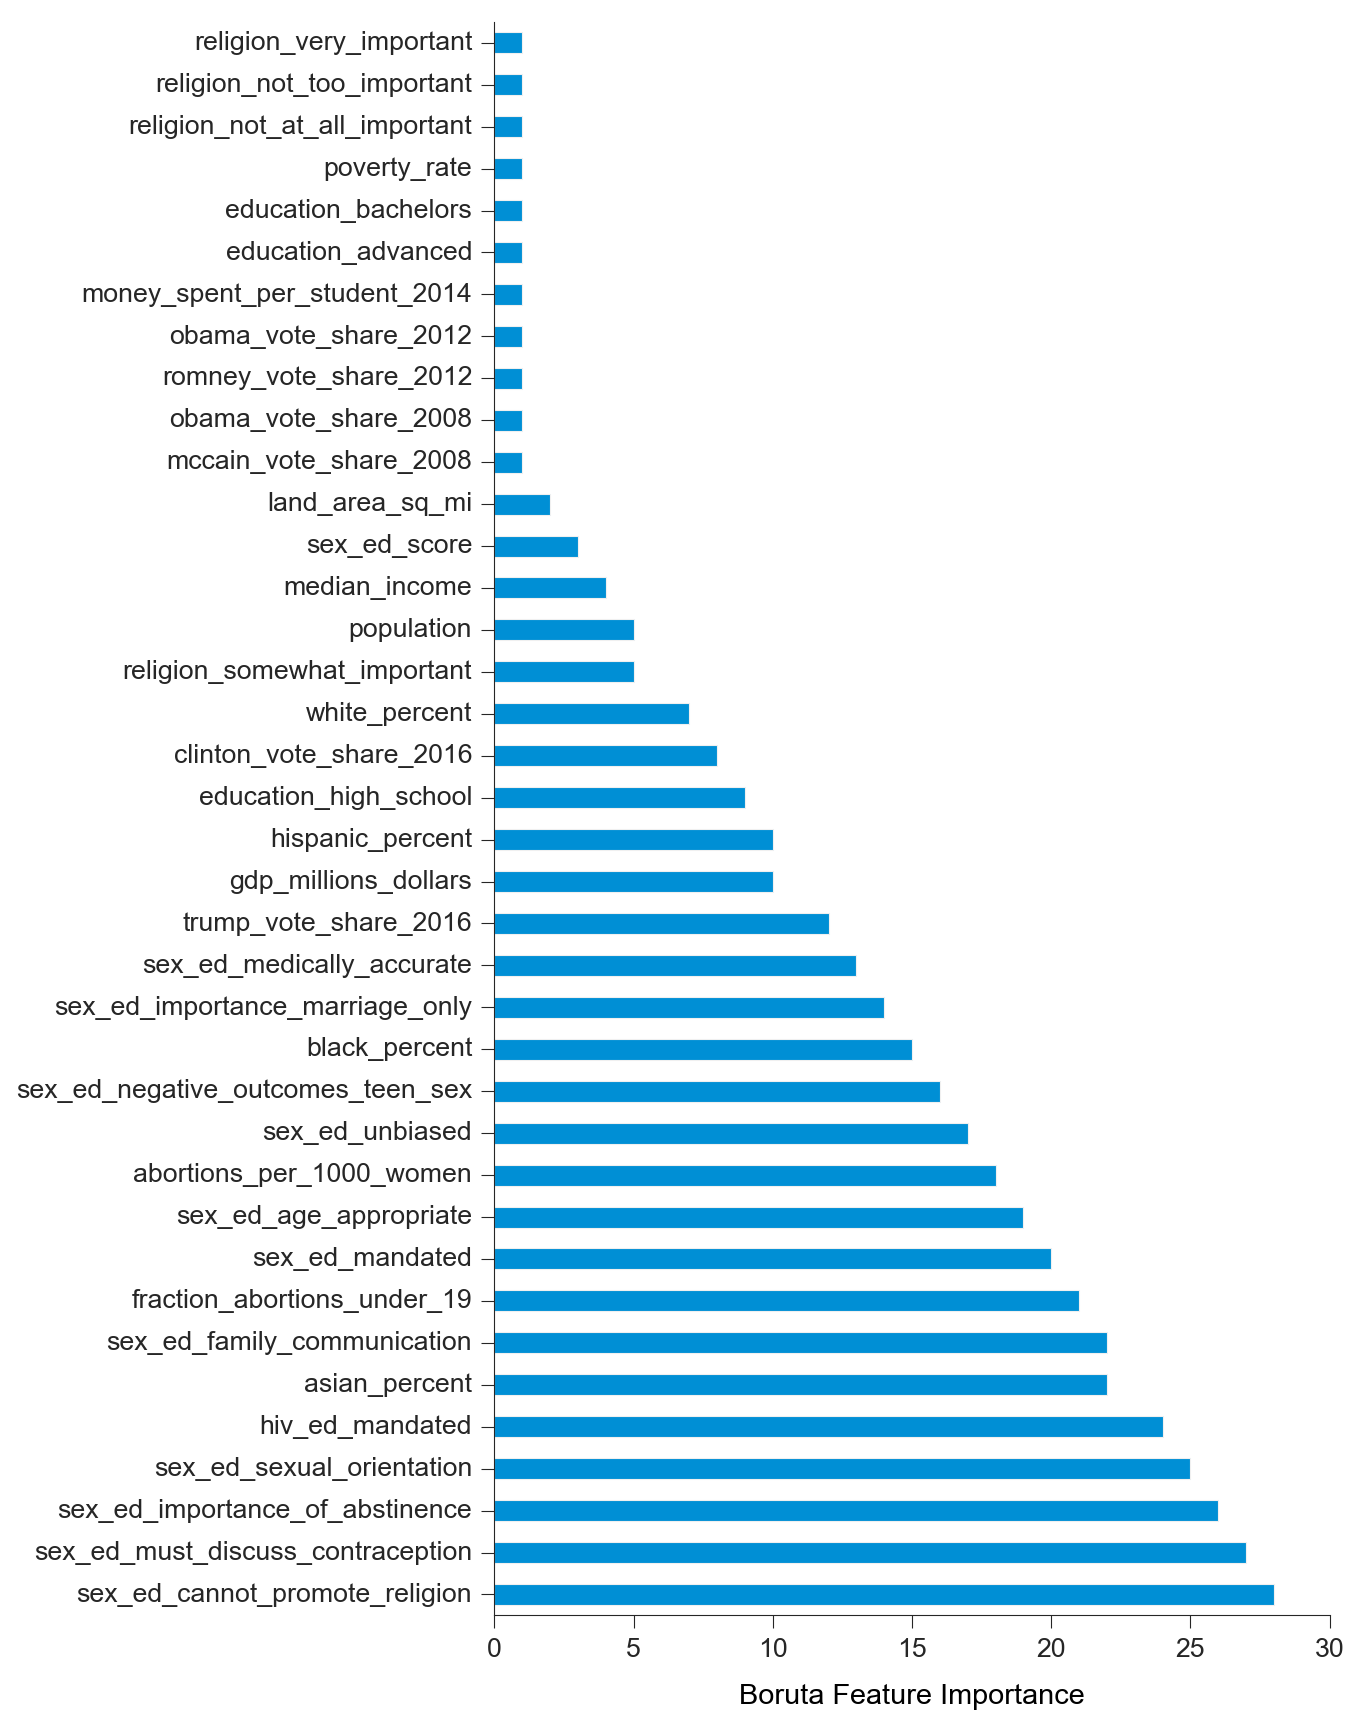

In [19]:
plot_feature_importance(boruta_selector.ranking_, label='Boruta Feature Importance', asc=False);

## 2.8 Aggregating Feature Importance
Below, I aggregated all of the feature importance scores from the 5 methods described above and calculated the average and median importances. Each feature importance ranking was made positive using the absolute values and scaled to fall within 0 and 1 to ensure equal weight amongst each comparison method. As a result, these rankings do not show directionality, only absolute importance.

In [20]:
results = [correlations[1:], ridge.coef_, lass.coef_, mif_scores, 
               rf.feature_importances_, boruta_selector.ranking_.astype('float')]
names = ['correlations', 'ridge', 'lasso', 'mutual_info_regression', 'random_forest', 'boruta']

def results_aggregate(results, names):
    
    combined_results = pd.DataFrame(index=X.columns)
    from sklearn.preprocessing import MinMaxScaler
    scale = MinMaxScaler()

    for i, result in enumerate(results):
        try:
            result = result.values.reshape(-1, 1)
        except:
            result = result.reshape(-1, 1)
    
        result = scale.fit_transform(abs(result))
    
        if names[i] == 'boruta':
            result = 1 - result
        
        result = pd.DataFrame(result, index=X.columns, columns=[names[i]])
        combined_results = pd.merge(combined_results, result, left_index=True, right_index=True)
    
    combined_results['mean_result'] = combined_results.mean(axis=1)
    combined_results['median_result'] = combined_results.median(axis=1)

    combined_results.sort_values(by='median_result', ascending=True, inplace=True)
    
    return combined_results

As shown in the aggregated rankings below, poverty rate seems to be the most significant predictor of teen birth rate. Religiosity in the state seems to be second most important, as the next 3 features are all related to religion. 4 out of the next 5 metrics involve the political leanings of the states based on the 2008 and 2012 elections. Finally, education and money spent per student in each state are shown. Due to the collinearity of many of these variables, I will perform feature engineering in the next section and combine relevant features into one single metric that captures these relationships.

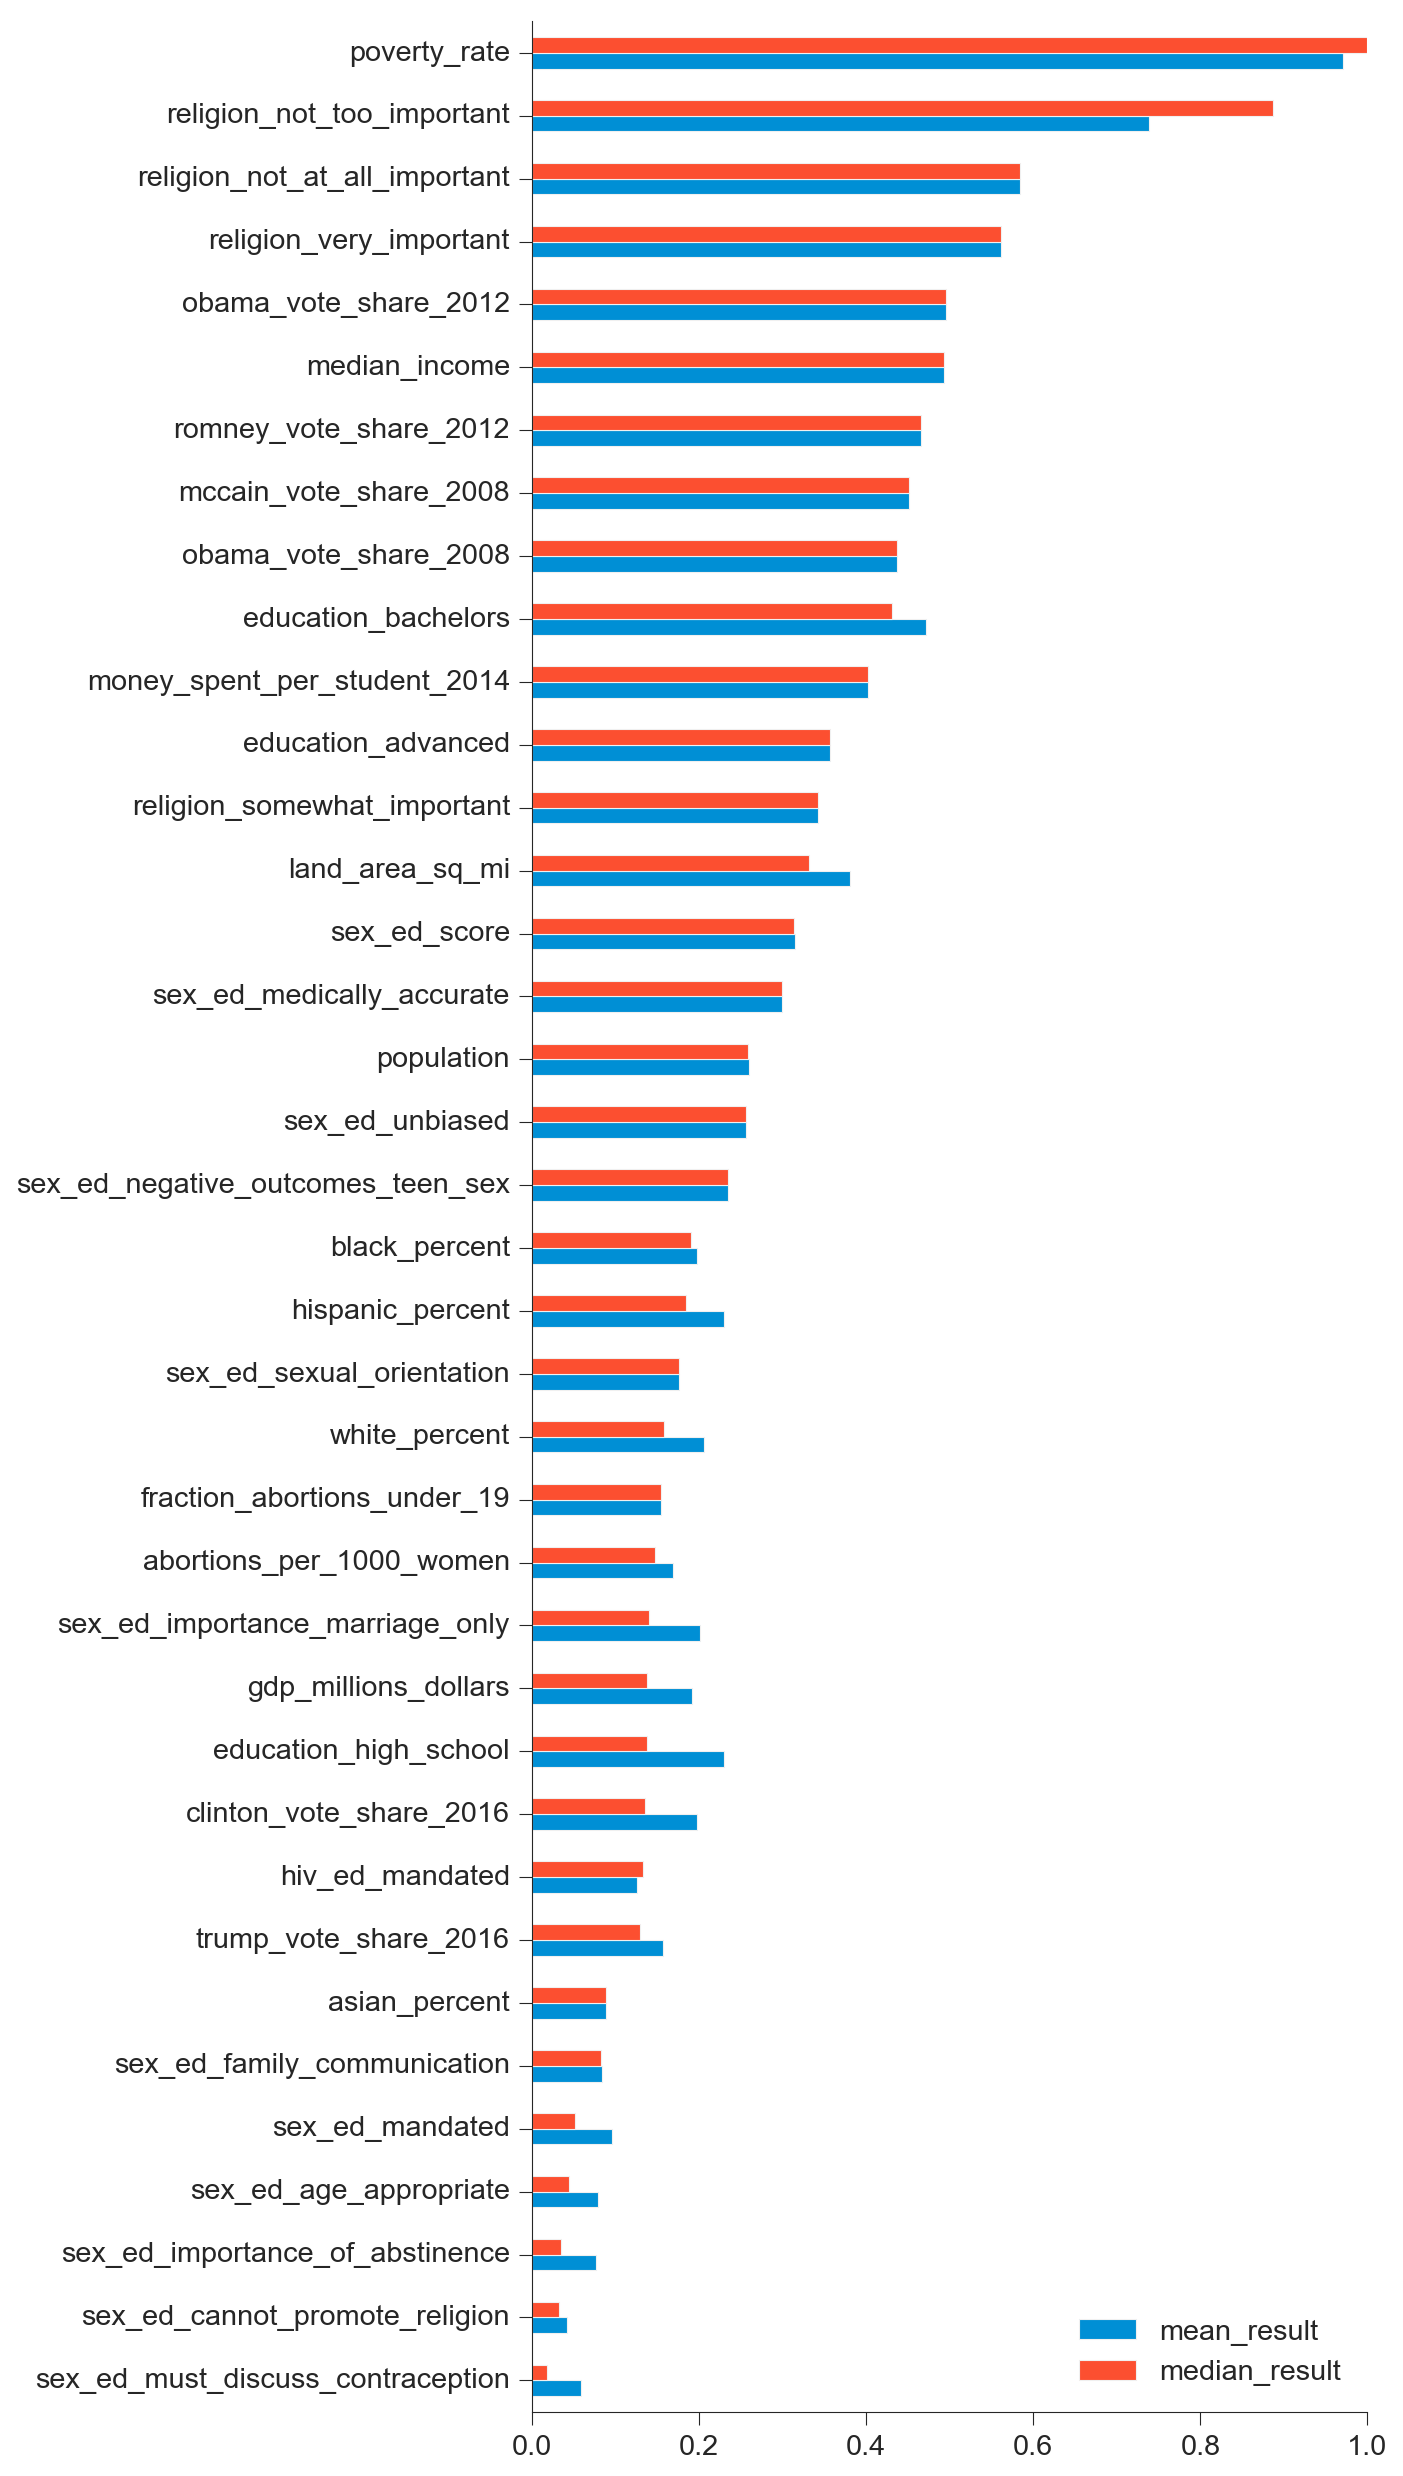

In [21]:
agg_results = results_aggregate(results, names)
agg_results[['mean_result', 'median_result']].plot.barh(figsize=(6,18), fontsize=13);

## 2.9 Adjusted R-Squared Analysis
Aside from the weights shown above, I wanted to explore how much new information each subsequent feature adds to the overall model accuracy. Below, I add each feature one-by-one in order of the aggregated importance, as shown in the plot above. A linear regression model is then fit with the available features and the adjusted r-squared value is calculated for the model. A plot showing the adjusted r-squared as each feature is added to the model is shown below.

In [22]:
def adj_rsquared_plot(agg_results):
    agg_features = []
    adj_rsquared = [0]

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    for feature in list(reversed(agg_results.index)):
        agg_features.append(feature)
        df_subset = data[agg_features]
    
        scale = StandardScaler()
        X_norm_sub = scale.fit_transform(df_subset)
        X_norm_sub = add_constant(X_norm_sub)

        sm = OLS(y, X_norm_sub)
        results = sm.fit()
    
        adj_rsquared.append(results.rsquared_adj)
    
    r2_plot = pd.DataFrame([range(len(adj_rsquared)), adj_rsquared]).T
    r2_plot = r2_plot.rename(columns={0:'# of features', 1:'adj_rsquared'})
    ax = r2_plot.plot.scatter('# of features', 'adj_rsquared', s=50)
    ax.set_ylim(0,1)
    ax.set_xlim(0,30);

The figure below shows that the first 7 features seem to add significantly new information in explaining the teen birth rate variance as measured by adjusted r-squared. At that point, the adjusted r-squared seems to level out, with a small increase between features 15-20. The relevant features for these two increasing slopes are shown below.

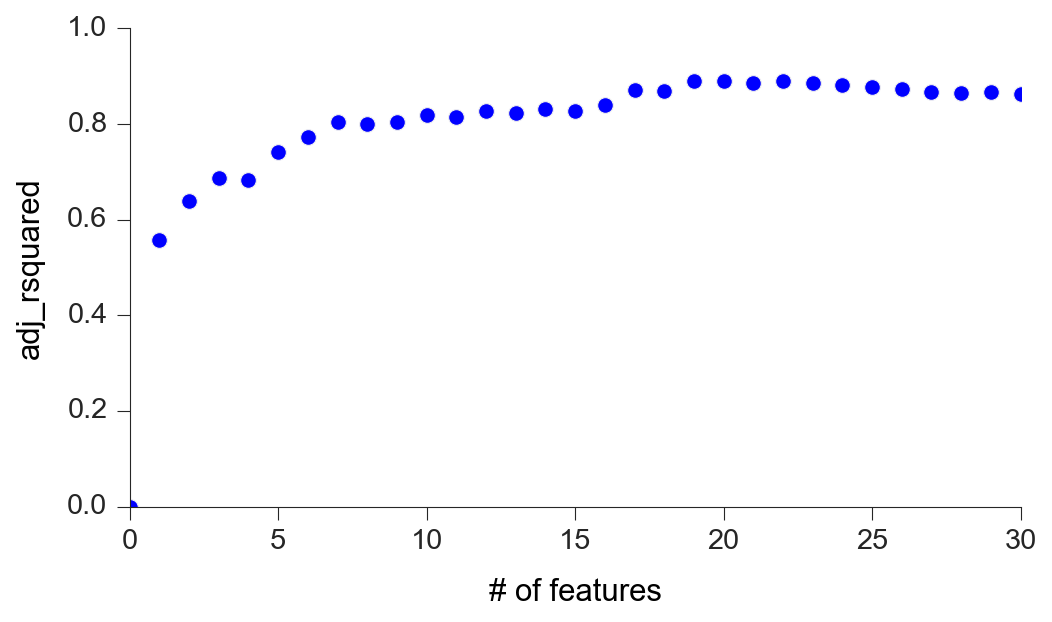

In [23]:
adj_rsquared_plot(agg_results)

In [58]:
print('Features 1–7:')
list(reversed(agg_results.index))[:7]

Features 1–7:


['poverty_rate',
 'religiosity',
 'republican_lean_08_12',
 'median_income',
 'education_level',
 'money_spent_per_student_2014',
 'sex_ed_quality']

In [60]:
print('Features 15-20:')
list(reversed(agg_results.index))[15:20]

Features 15-20:


['gdp_millions_dollars',
 'clinton_vote_share_2016',
 'black_percent',
 'sex_ed_mandated',
 'sex_ed_age_appropriate']

# 3. Feature Collinearity
Because many of the significant features discovered above are related to each other, I will explore the collinearity of the various features using heatmaps. The function below generates heatmaps that contain features that positively or negatively correlate with the target teen birth rate, as well as the strongest correlations regardless of directionality.

In [26]:
def heatmap_plot(data, corr_type='pos', num_to_plot=15, figsize=(10,8)):
    correlation_matrix = data.corr()

    if corr_type == 'pos':
        top_columns = correlation_matrix.nlargest(num_to_plot, 'teen_birth_rate').index
        filtered_matrix = correlation_matrix.nlargest(num_to_plot,'teen_birth_rate')[top_columns]
    
    elif corr_type == 'neg':
        top_columns = ['teen_birth_rate']
        top_columns.extend(correlation_matrix.nsmallest(num_to_plot, 'teen_birth_rate').index)
        filtered_matrix = correlation_matrix.nsmallest(num_to_plot, 'teen_birth_rate')[top_columns]
        
    elif corr_type == 'abs':
        correlation_matrix = abs(correlation_matrix)
        top_columns = correlation_matrix.nlargest(num_to_plot, 'teen_birth_rate').index
        filtered_matrix = correlation_matrix.nlargest(num_to_plot,'teen_birth_rate')[top_columns]
        
    plt.figure(figsize=figsize)
    sns.set(font_scale=1);
    sns.heatmap(filtered_matrix, cbar=True, cmap="YlGnBu", annot=True, 
                square=False, fmt='.2f', annot_kws={'size': 10});

    PrettyPlot(plt);

## 3.1 Pre-Feature Engineering
Below I show the feature correlations before performing any engineering to combine similar metrics.

### 3.1.1 Positive Correlations
As shown below, features such as the McCain and Romney vote shares exhibit very strong collinearity. Other strong collinearities include the poverty rate - religion_very_important and some sexual education metrics.

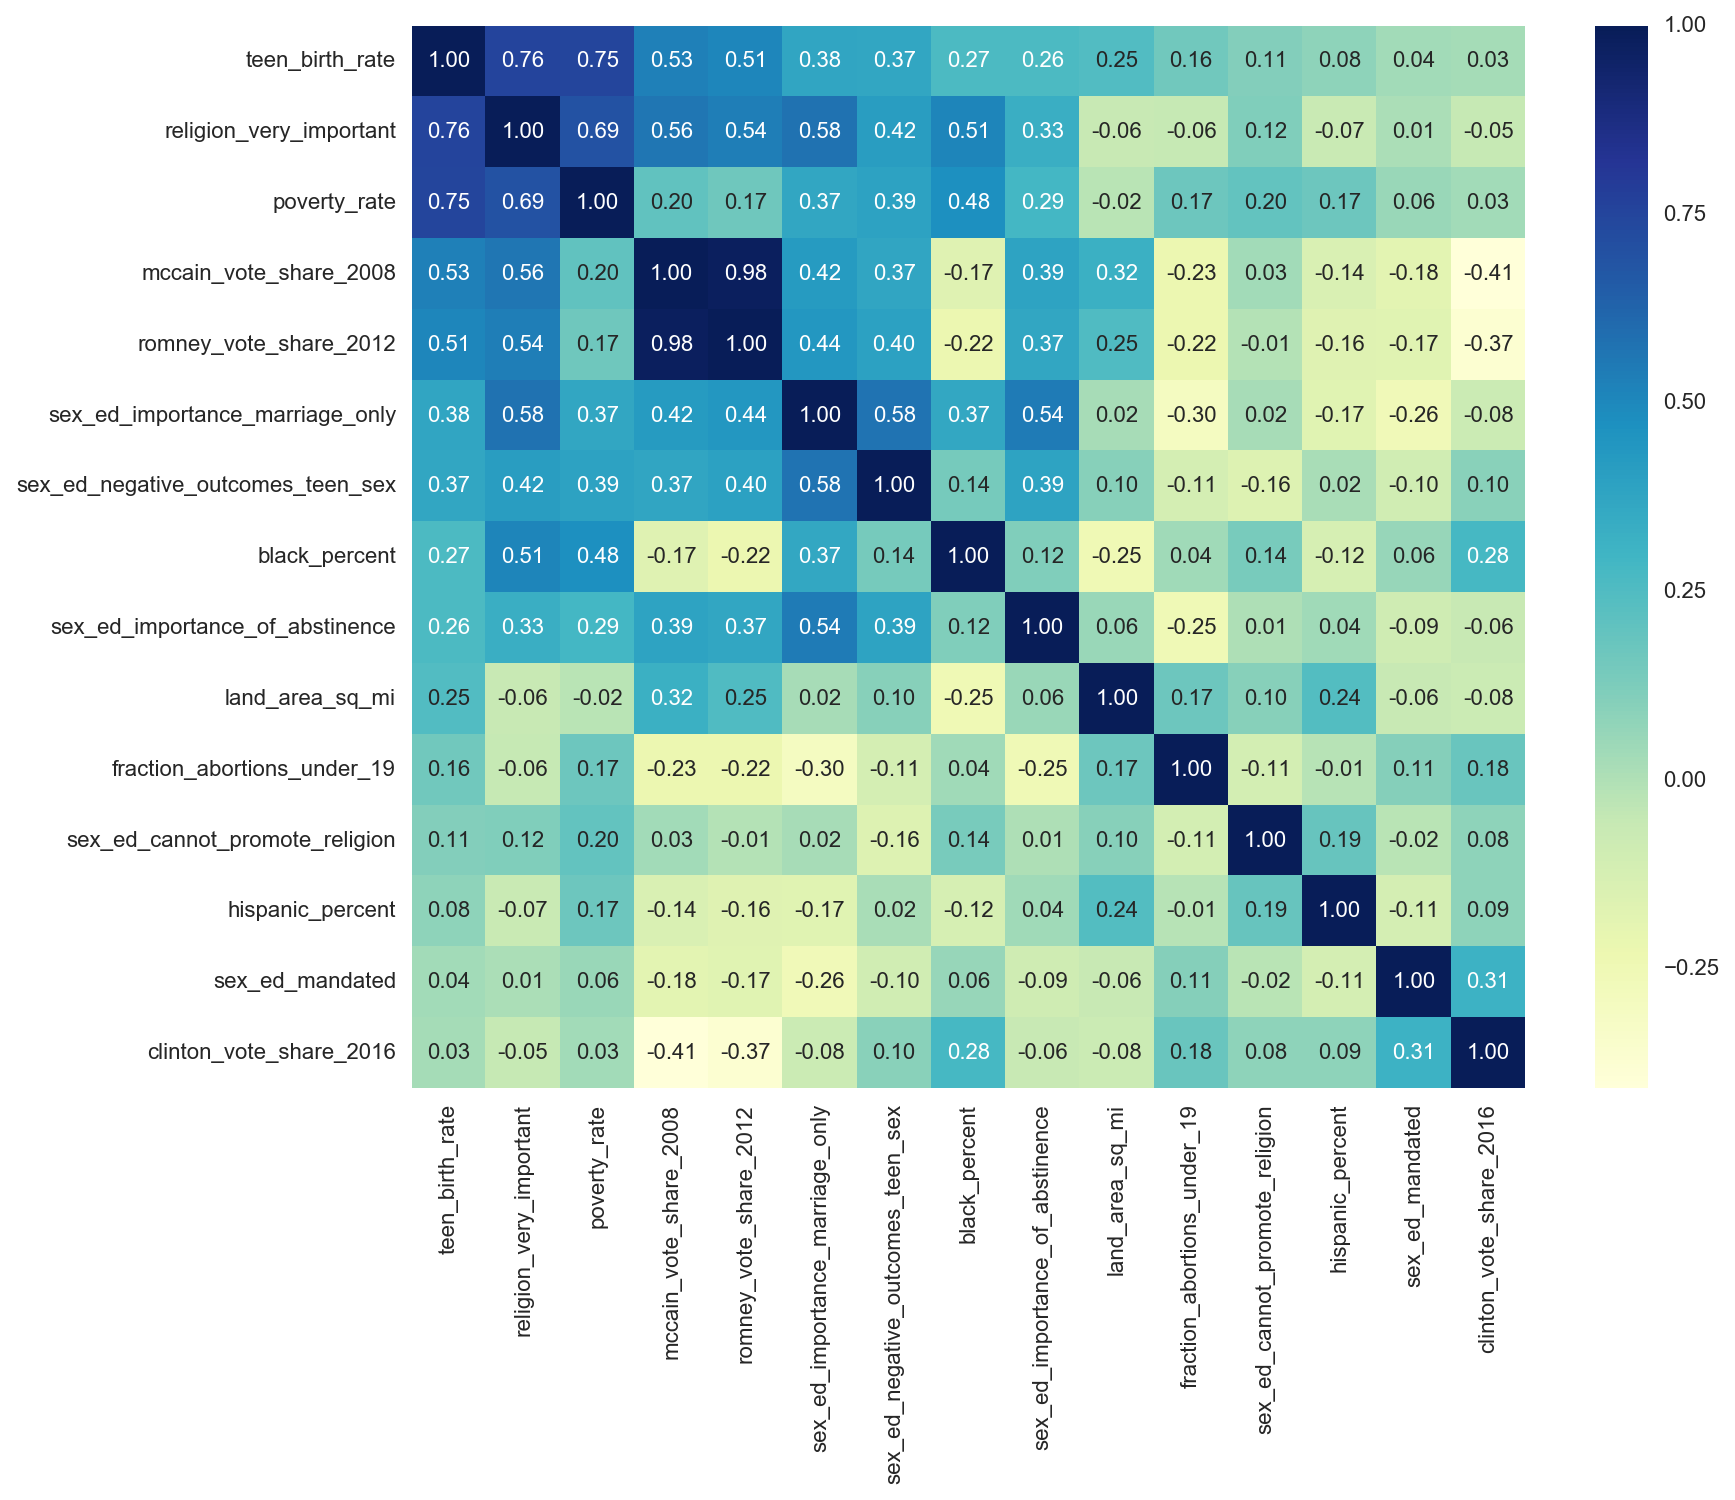

In [27]:
heatmap_plot(data, corr_type='pos', num_to_plot=15)

### 3.1.2 Negative Correlations
Three of the religion metrics (not too important, not at all important, and somewhat important) all exhibit strong negative correlations with teen birth rate (far left column). Further, these responses also exhibit relatively high collinearity. The Obama vote shares from 2008 and 2012 also exhibit very high collinearity, along with education.

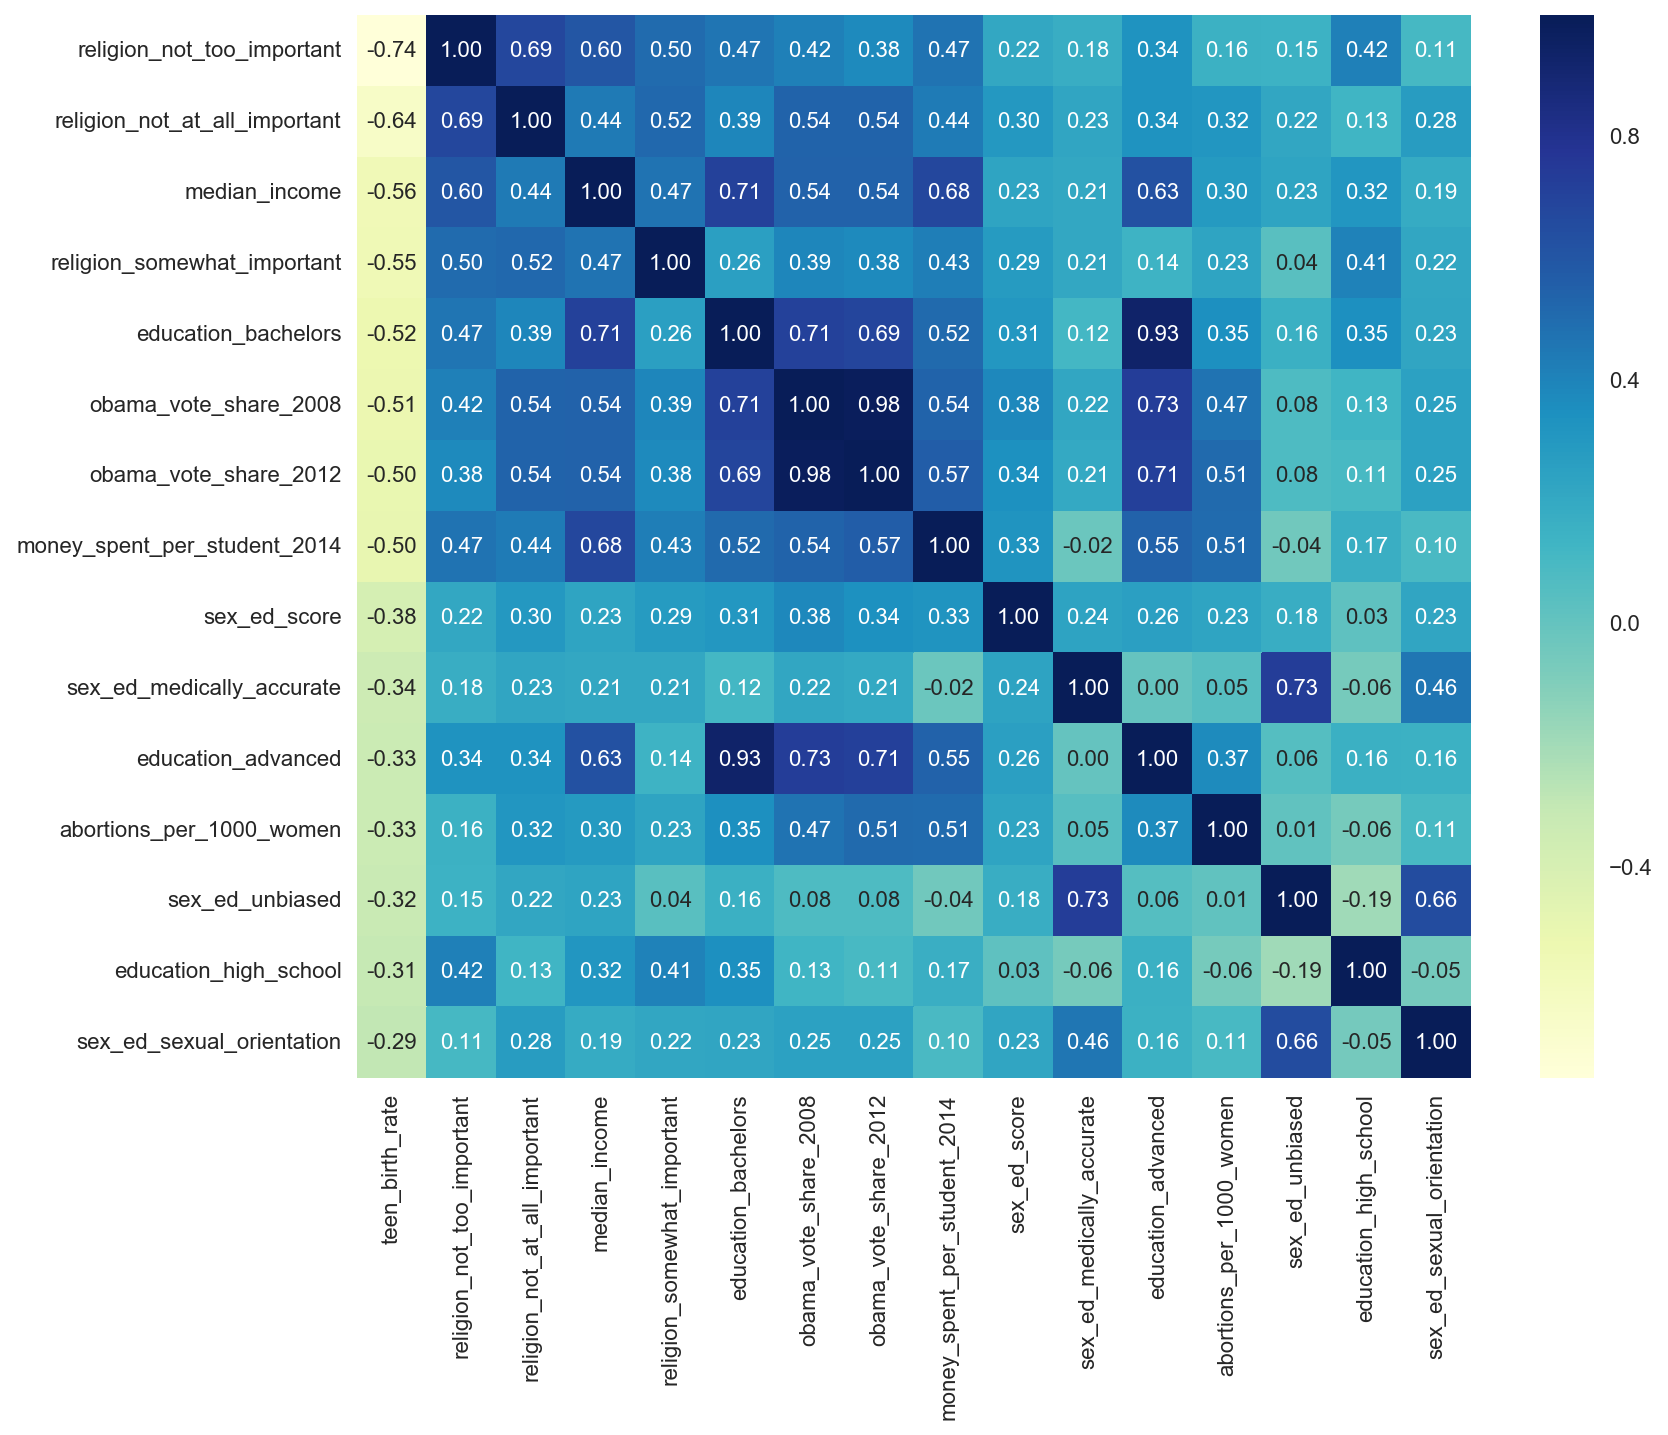

In [28]:
heatmap_plot(data, corr_type='neg', num_to_plot=15)

## 3.2 Feature Engineering
Due to the multicollinearity between critical features, I will create a single metric for some of these in order to better capture their importance with a single variable.

I will create four combined variables for religion importance, political leanings, education level of the state population, and the focus of sexual education teachings, as follows:
- religiosity = (religion very important) / ( religion somewhat important + religion not too important + religion not at all important)
- republican_lean = (Romney '12 share + McCain '08 share) - (Obama '12 share + Obama '08 share)
- education_level = percent high school educated + percent bachelors educated + percent advanced degree educated
- sex ed focus = (unbiased teachings + medically accurate teaching + sex ed score) / (abstinence focus + marriage sex only + negative outcomes of teen sex)

While these metrics are arbitrary, they capture relationships between related variables so that their importance is not spread out among multiple features. They also incorporate the general directionality of the correlation with the response (i.e. differencing the positive correlations of Romney+McCain from the negative correlations of Obama).

In [29]:
def data_drop(df, cols):
    df = df.drop(cols, axis=1)
    return df

### 3.2.1 Religiosity

In [30]:
religion = ['religion_very_important', 'religion_not_too_important',
            'religion_somewhat_important', 'religion_not_at_all_important']

data['religiosity'] = data[religion[0]] / (data[religion[1]] + data[religion[2]] + data[religion[3]])
data = data_drop(data, religion)

### 3.2.2 Political Preferences 

In [31]:
d_vs_r = ['romney_vote_share_2012', 'mccain_vote_share_2008',
           'obama_vote_share_2008', 'obama_vote_share_2012']

data['republican_lean_08_12'] = (data[d_vs_r[0]] + data[d_vs_r[1]]) / (data[d_vs_r[2]] + data[d_vs_r[3]])
data = data_drop(data, d_vs_r)

### 3.2.3 Education Level

In [32]:
edu = ['education_bachelors', 'education_advanced', 'education_high_school']

data['education_level'] = data[edu[0]] + data[edu[1]] + data[edu[2]]
data = data_drop(data, edu)

### 3.2.4 Sex Ed Teachings

In [33]:
sex_ed = ['sex_ed_medically_accurate', 'sex_ed_unbiased', 'sex_ed_score',
          'sex_ed_importance_marriage_only', 'sex_ed_negative_outcomes_teen_sex', 'sex_ed_importance_of_abstinence']
scaled_score = scale.fit_transform(data[sex_ed[2]].values.reshape(-1, 1))[:,0]

data['sex_ed_style'] = (scaled_score + data[sex_ed[0]] + data[sex_ed[1]]) / \
                         (data[sex_ed[3]] + data[sex_ed[4]] + data[sex_ed[5]] + 1)
data = data_drop(data, sex_ed)

### 3.2.5 Positive Correlations New Features
The positive correlations are shown after calculating the new features. The religiosity and republican_lean features show the second and third highest correlations with the teen birth rate, after poverty level.

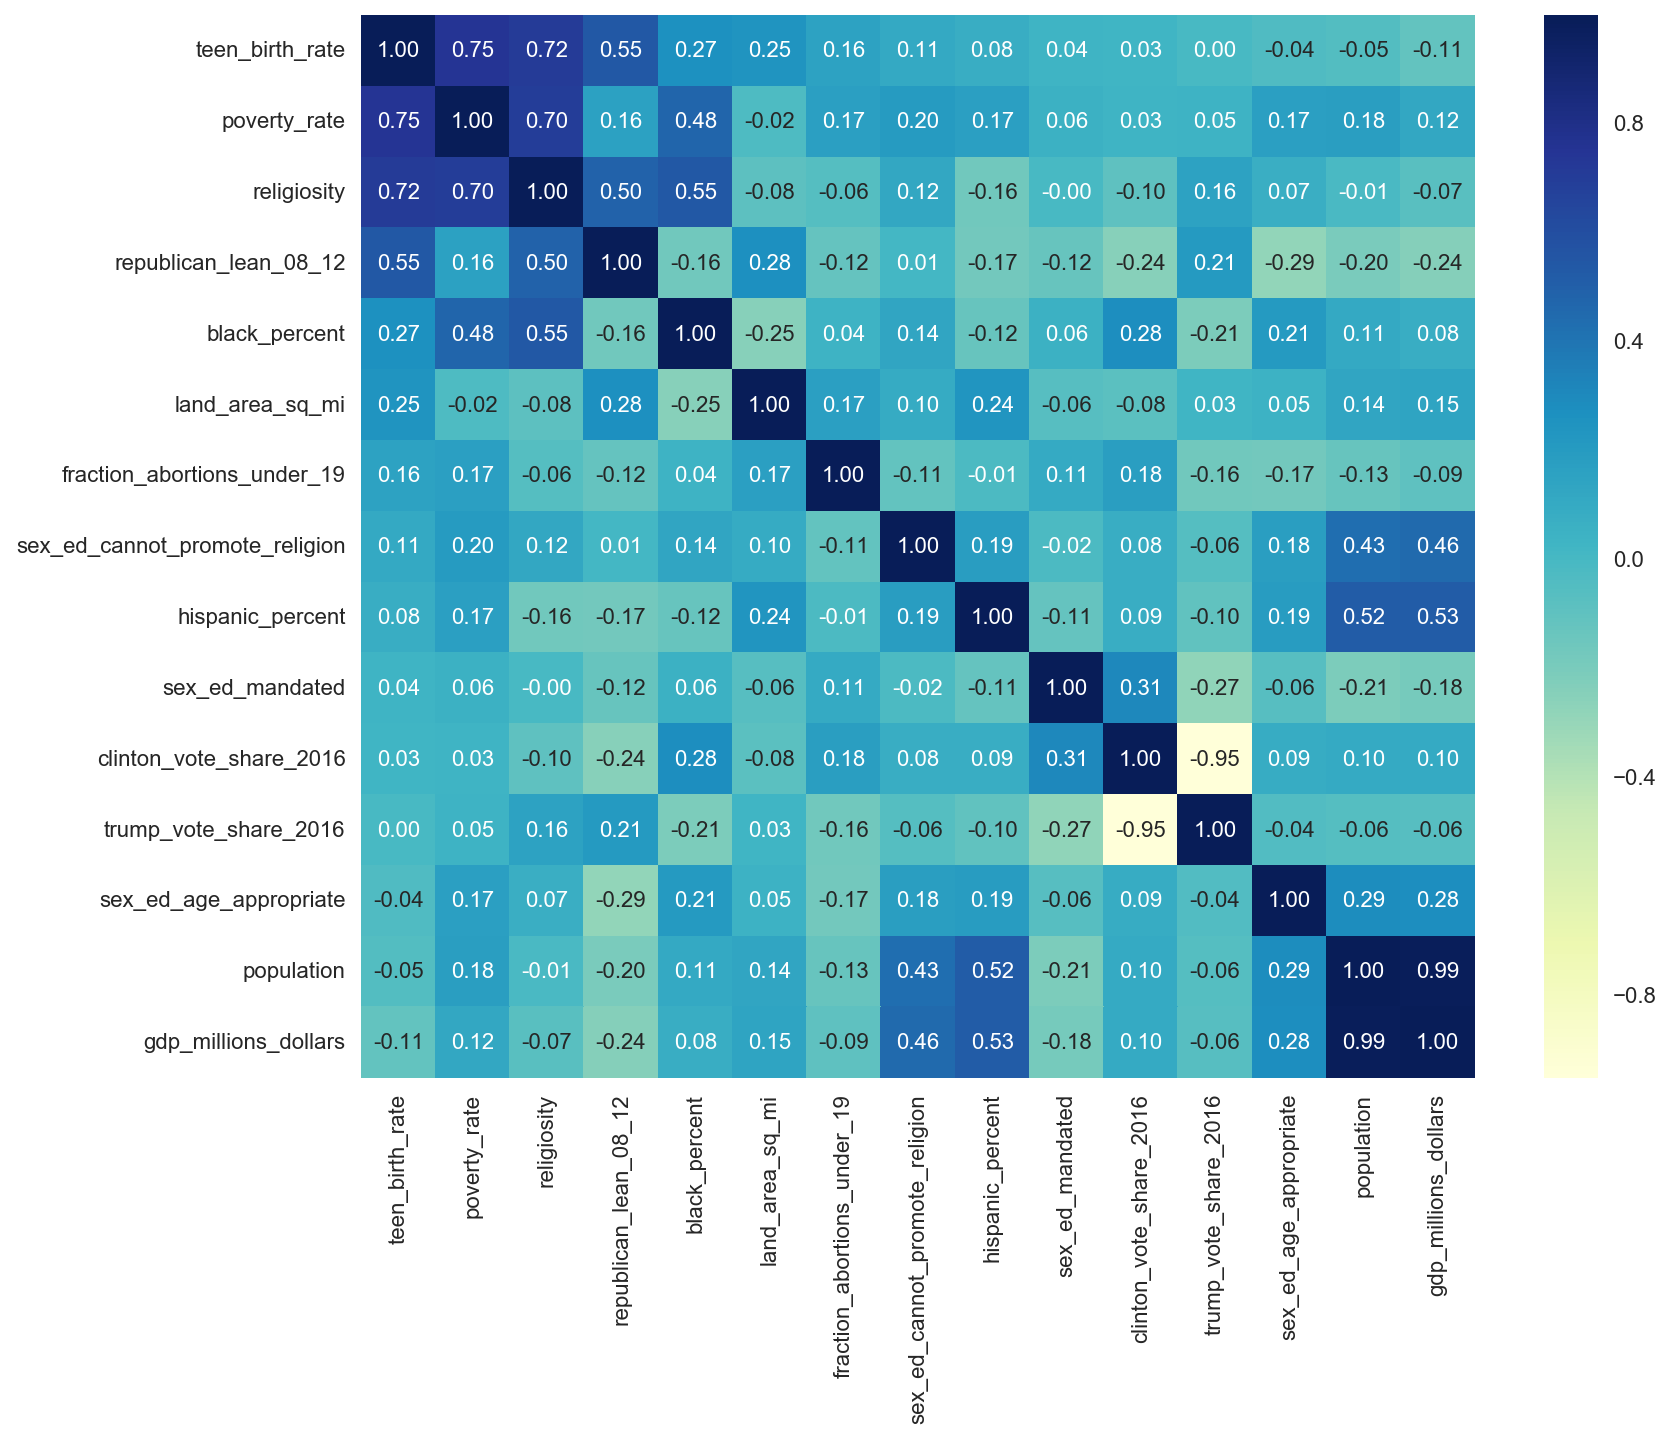

In [34]:
heatmap_plot(data, corr_type='pos', num_to_plot=15)

### 3.2.6 Negative Correlations New Features
The sex_ed_quality and education_level features show the 1st and 3rd highest negative correlations with the teen birth rate.

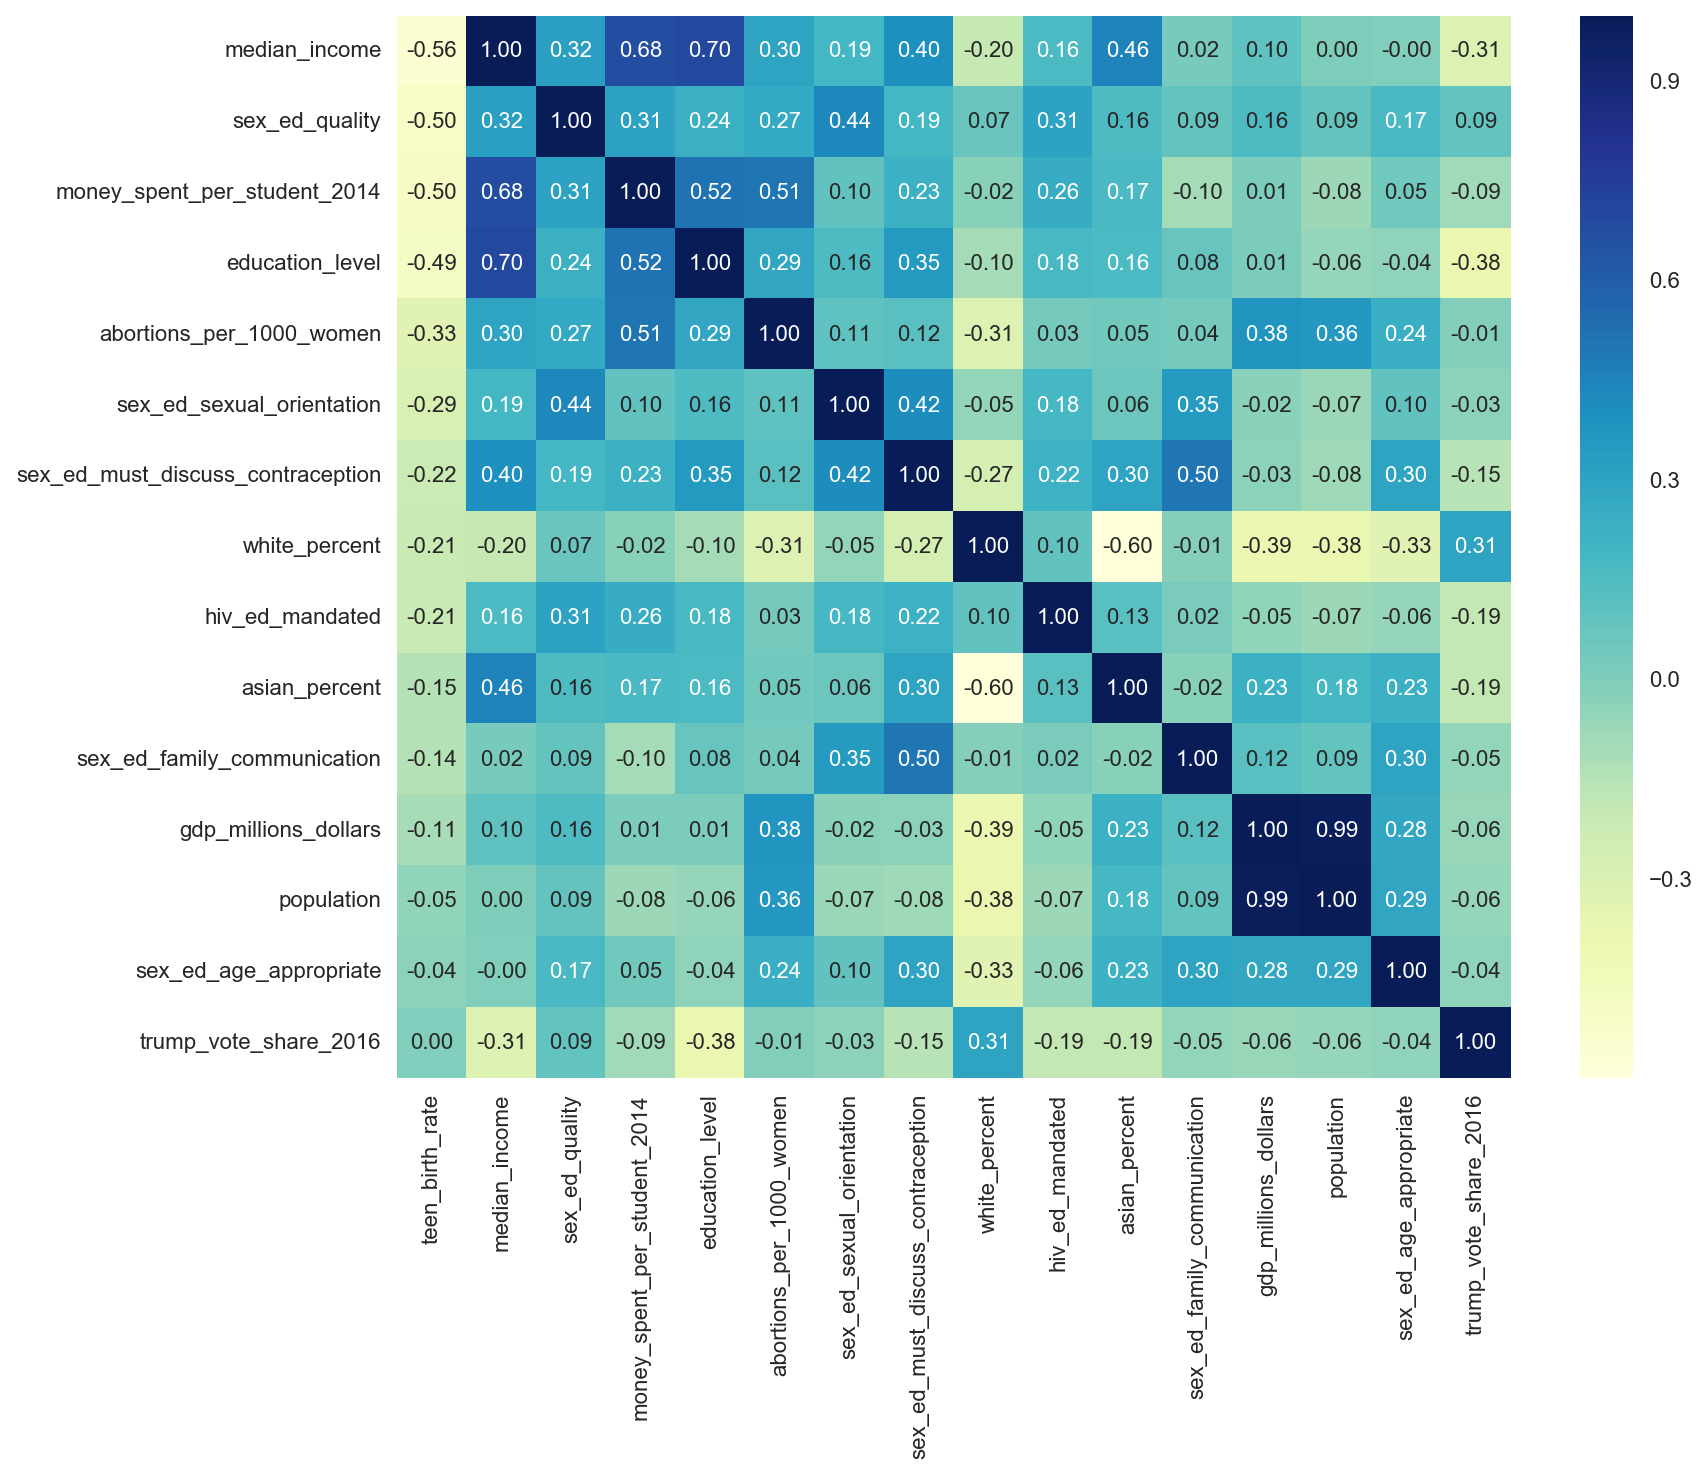

In [35]:
heatmap_plot(data, corr_type='neg', num_to_plot=15)

# 4. Feature Selection with Engineered Features
I will repeat the feature selection models shown in Section 2 with the new dataset that contains the combined variables for religion, politics, education, and sexual education. I will only show the RMSE values, as opposed to the individual feature importance plots. However, the final aggregate weightings of each feature will be shown at the end. It should be noted that the out of sample RMSE values dropped slightly with the loss of information due to feature aggregation, but overall remained very similar to the RMSE's from Section 2.

## 4.1 Individual Model Feature Selection

In [36]:
correlations = data.corr().iloc[:,0][1:]

In [37]:
y = data.teen_birth_rate
X = data.select_dtypes(include=['float']).drop('teen_birth_rate', axis=1)

scale = StandardScaler()
X_norm = scale.fit_transform(X)

In [38]:
ridge = Ridge(alpha=25)
cross_val_mean(X_norm, ridge)
ridge.fit(X_norm, y);

Cross-validated RMSE: 0.369


In [39]:
lasso = Lasso(alpha=0.05)
cross_val_mean(X_norm, lasso)
lass.fit(X_norm, y);

Cross-validated RMSE: 0.372


In [40]:
mif_scores = mutual_info_regression(X_norm, y, discrete_features='auto', n_neighbors=3, copy=True)

In [41]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
cross_val_mean(X, rf)
rf.fit(X, y);

Cross-validated RMSE: 0.385


In [42]:
from boruta_py import BorutaPy

boruta_selector = BorutaPy(RandomForestRegressor(n_jobs=-1), n_estimators='auto', verbose=0)
boruta_selector.fit(X.values, y.values);

## 4.2 Aggregating Results
The aggregated feature importances are shown in the plot below. Poverty rate is again shown as the most critical feature, followed by 3/4 of the new engineered features: religiosity, republican lean, and education level. Other critical features shown are median income and the money spent per student.

In [43]:
results = [correlations, ridge.coef_, lass.coef_, mif_scores, 
               rf.feature_importances_, boruta_selector.ranking_.astype('float')]
names = ['correlations', 'ridge', 'lasso', 'mutual_info_regression', 'random_forest', 'boruta']

agg_results = results_aggregate(results, names)

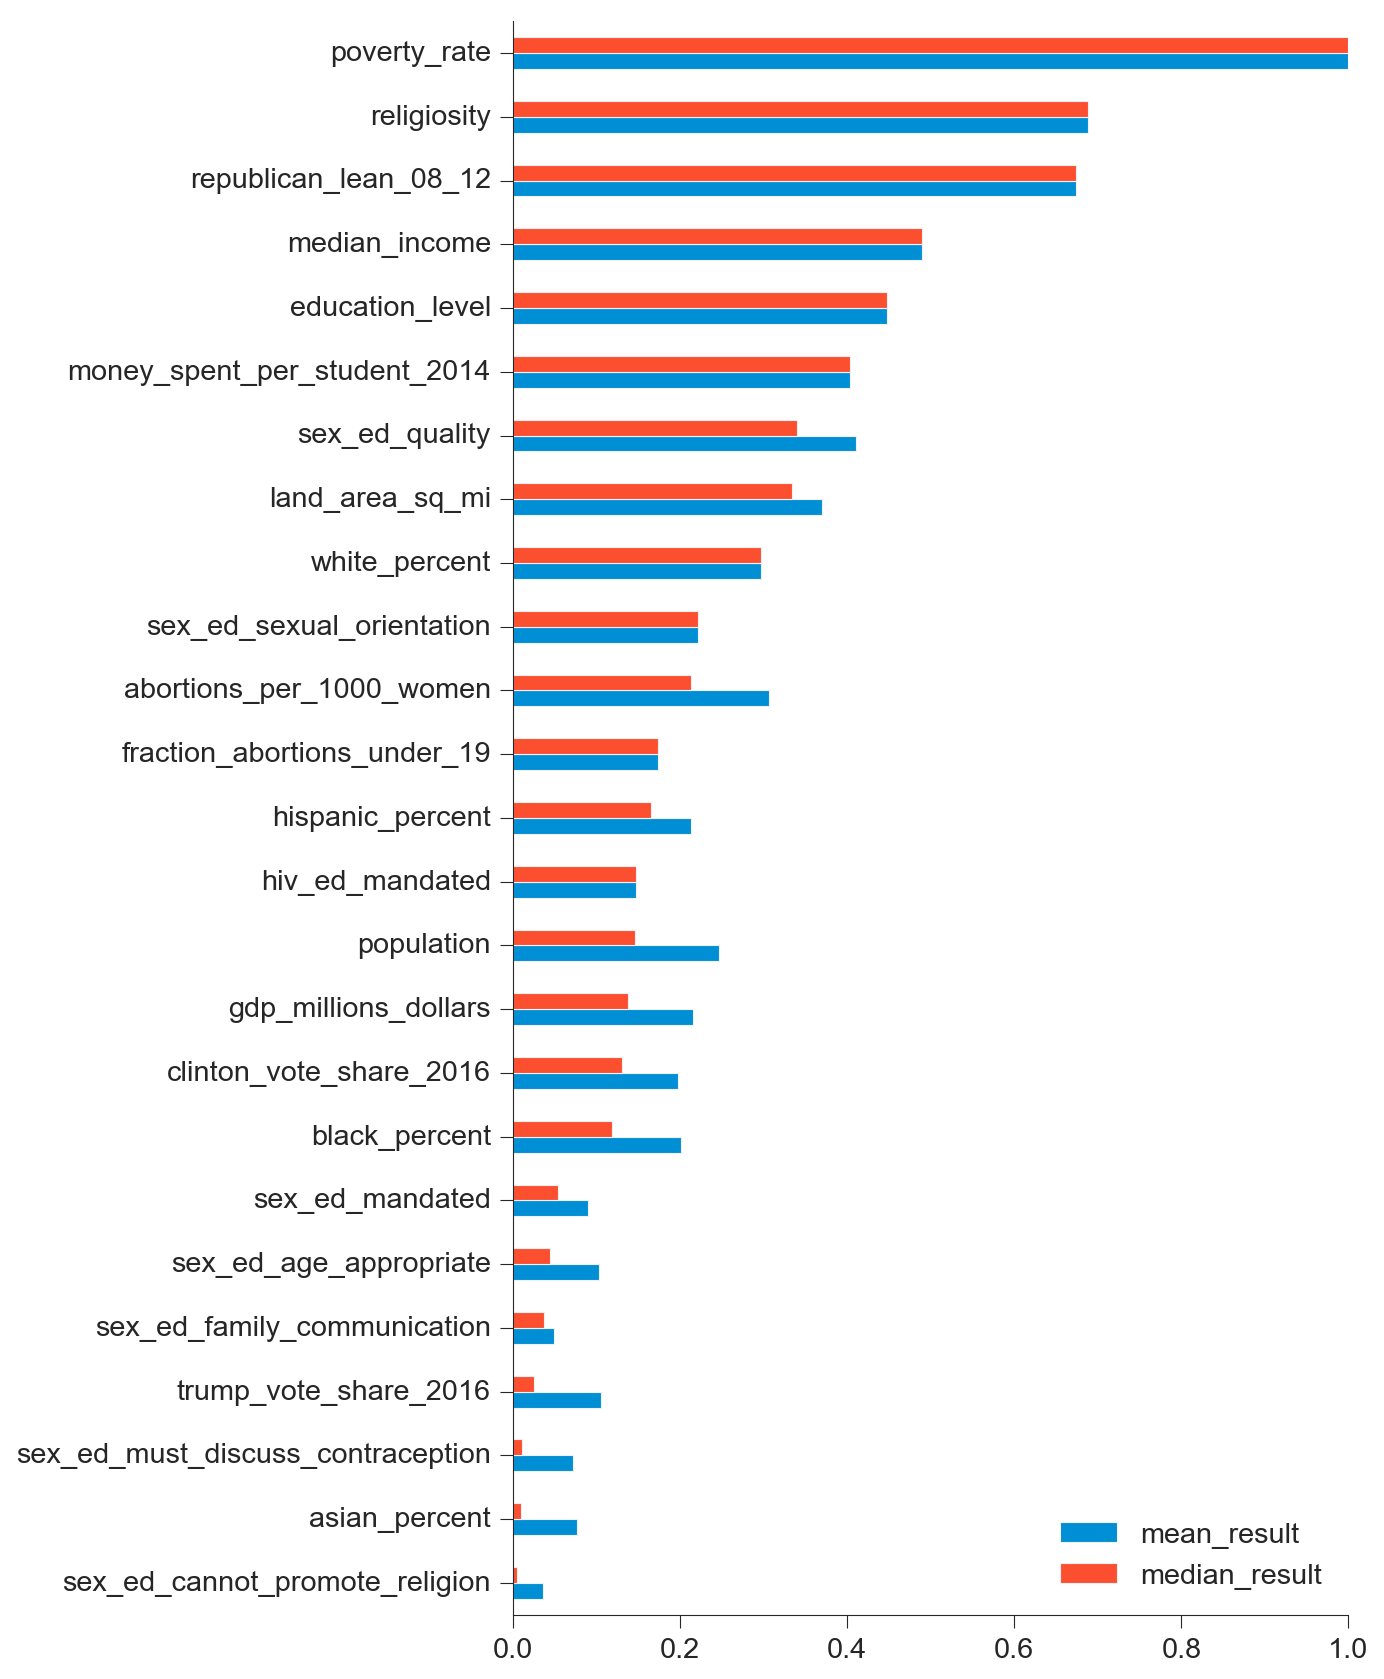

In [44]:
agg_results[['mean_result', 'median_result']].plot.barh(figsize=(6,12), fontsize=13);

## 4.3 Adjusted R-Squared Analysis
The plot below shows the adjustd r-squared value for a linear model as each feature from the aggregated results is added. The first three features all seem to add new information to the model, but it is relatively flat frm that point forward. The three features at the beginning are poverty rate, religiosity, and republican lean of the state. These three seem to be the most critical when it comes to explaining the teen birth rate in each state.

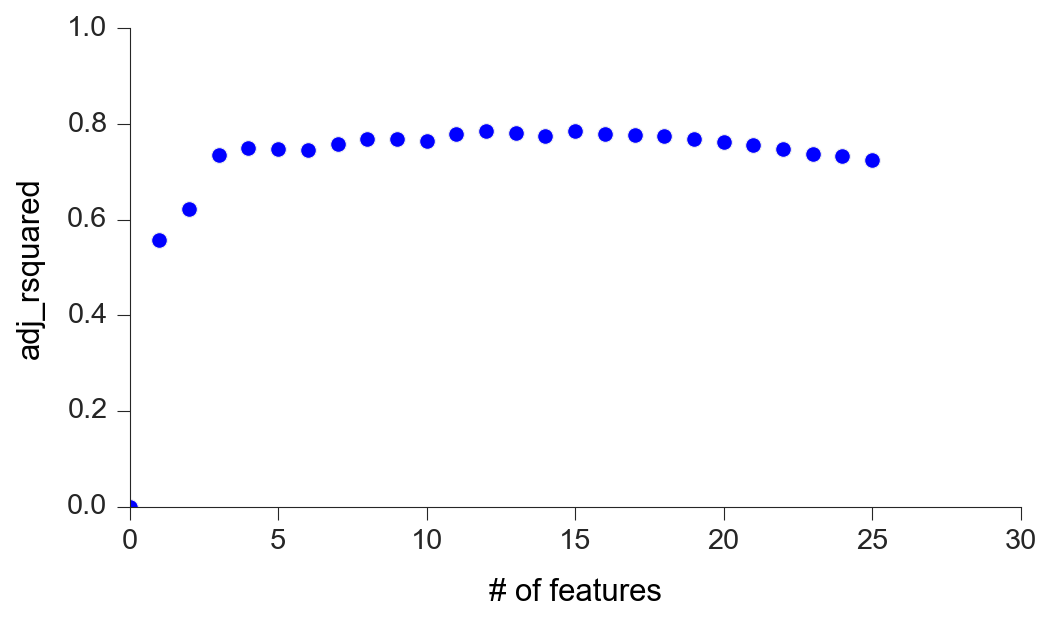

In [45]:
adj_rsquared_plot(agg_results)

In [63]:
print('Top three features:')
list(reversed(agg_results.index))[:3]

Top three features:


['poverty_rate', 'religiosity', 'republican_lean_08_12']

# 5. Results Summary and Visualization
The visualization below takes the three most important features (poverty rate, religiosity, and republican leaning for presidential elections) and creates a dot plot to show their association with the teen birth rate. The birth rate and each feature are normalized between 0 and 1, with 1 showing the highest occurence for any respective variable (i.e. 1 is the highest birth rate, highest birth rate, highest religion importance, and most republican leaning). The darker red dots further to the right indicate 1.

## 5.1 Visualization

/Users/Mark/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


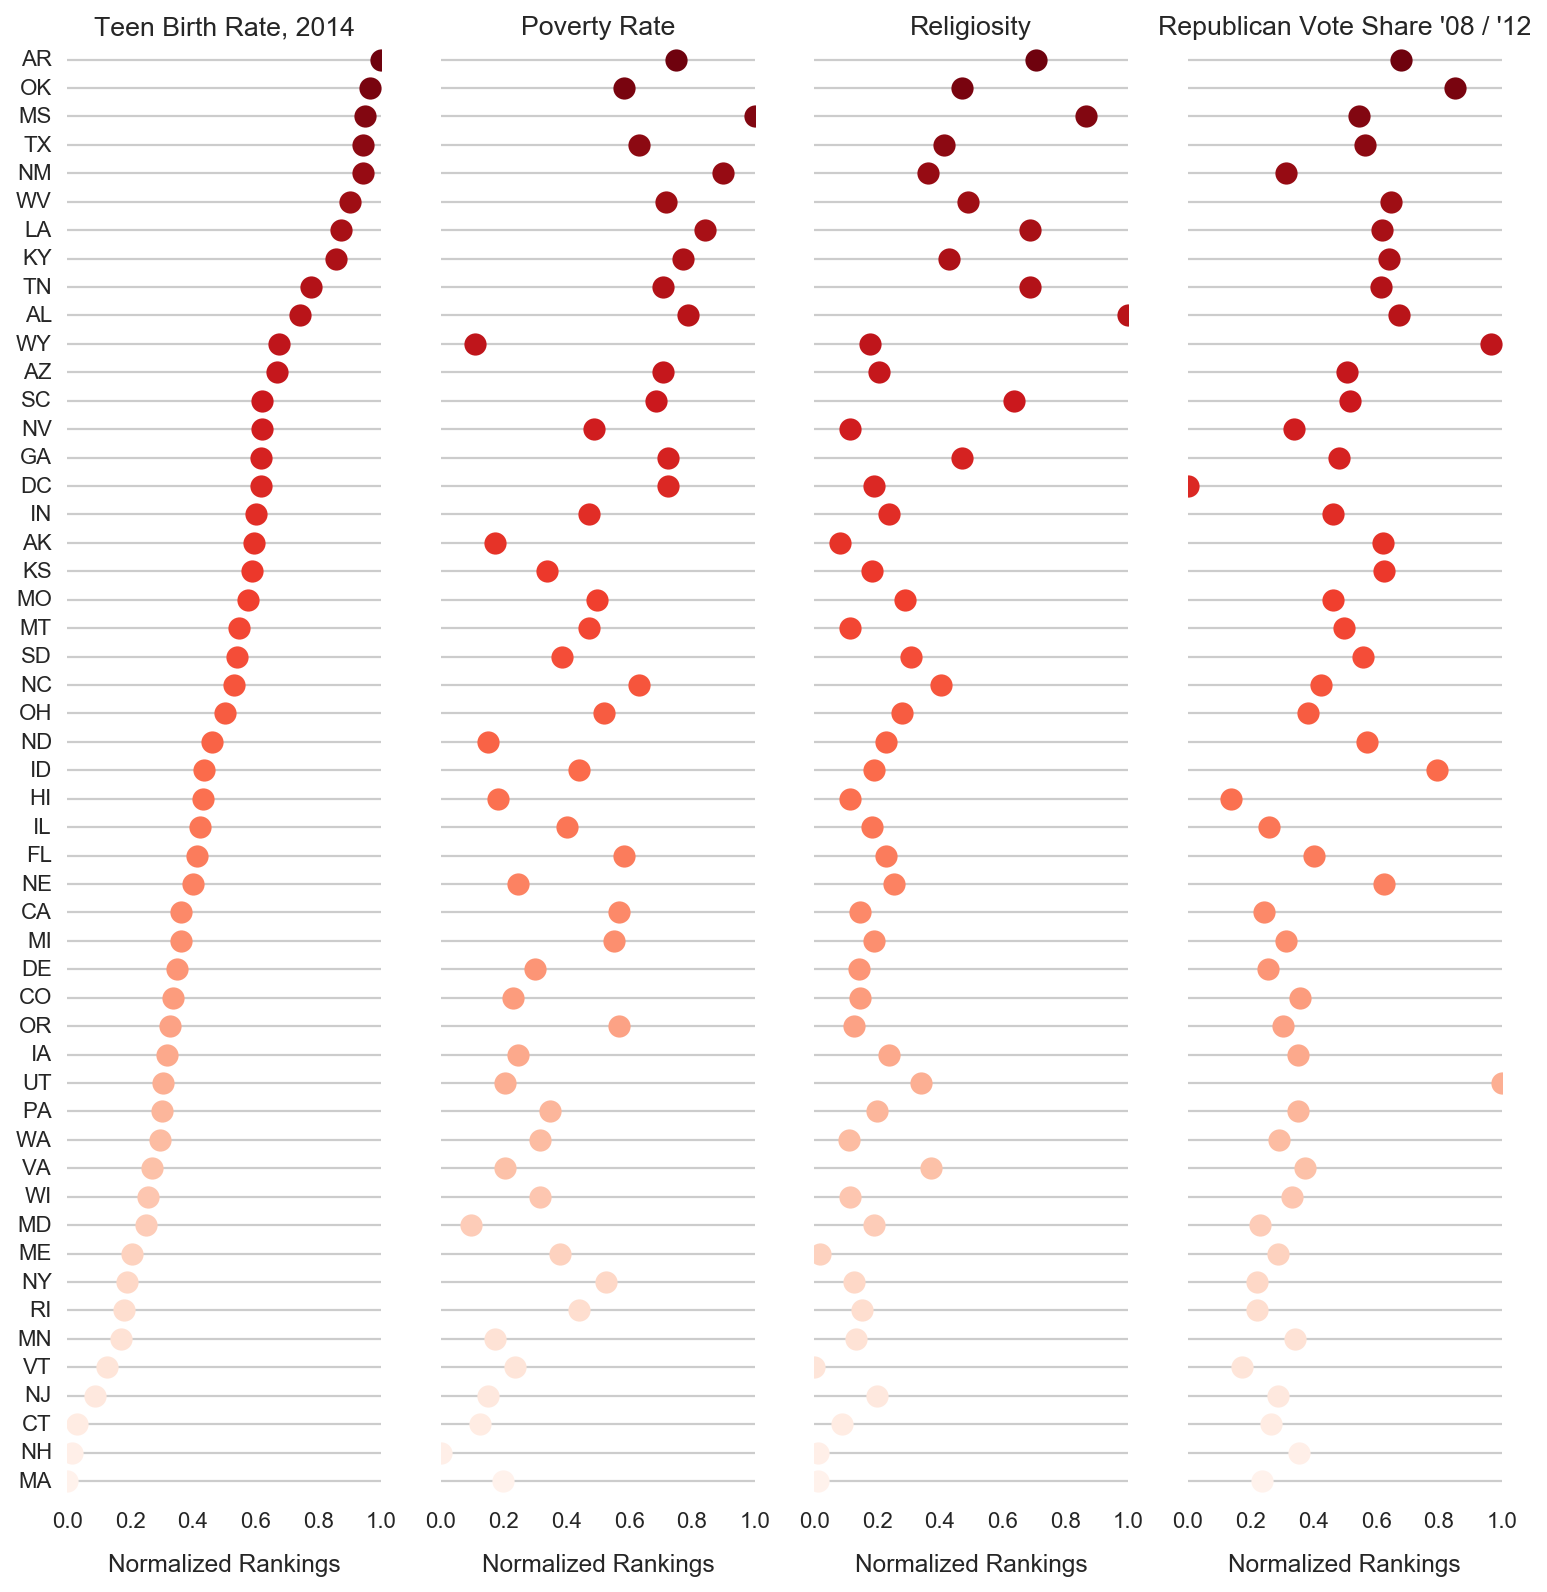

In [52]:
sns.set(style="whitegrid")

# Load the dataset
from sklearn.preprocessing import MinMaxScaler
top_features = data[['Code', 'teen_birth_rate', 'poverty_rate', 'religiosity', 'republican_lean_08_12']]
scale = MinMaxScaler()
top_features.iloc[:,1:] = scale.fit_transform(top_features.iloc[:,1:])

# Make the PairGrid
g = sns.PairGrid(top_features.sort_values('teen_birth_rate', ascending=False),
                 x_vars=top_features.columns[1:], y_vars=['Code'],
                 size=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel="Normalized Rankings", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['Teen Birth Rate, 2014', 'Poverty Rate', 'Religiosity', "Republican Vote Share '08 / '12" ]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.savefig('final_result.pdf', bbox_inches='tight')

## 5.2 Summary
In this analysis, I created a dataset in order to explain the teen birth rate in each state. I used various feature selection models that include univariate selection, as well as linear and multivariate modeling. I aggregated the feature importance results from each model and used an adjusted r-squared analysis of the resulting importances to find which features add new information. After combined related features into single metrics, I was able to explain ~75% of the variance in the teen birth rate with only three variables: the poverty rate, religion importance, and republican lean of each state. 

From a perspective of using this information, it seems that enacting policies to reduce poverty would be the most useful approach, as it's the strongest and most clear factor. The relationship between the birth rate and religion / political leanings is more complex. One thought could be that religion and politics influence the sexual education and abortion rates in each state. However, these separate variables did not show up as being significant when included separately, though the data for sexual education included many missing values that could degrade quality. Further the religiosity and republican leaning states tend to have higher poverty levels based on correlations (though they still added new information to the model). 

Modifying this analysis to include more granular politic data (e.g. county level), along with higher quality sexual education metrics would potentially shed better light on these complexities. However, the results do point to a potential "cultural" effect depending on the state's religious and political environment.